# TCdata360 Data Census Analysis

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import datetime
import re
import io

from scipy import stats
import statsmodels.api as sm
import scipy.cluster.hierarchy as hac
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

C:\Users\mrpso\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Set color palette

In [2]:
sns.set_style("darkgrid")

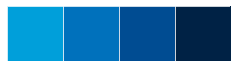

In [5]:
wbg_seq_pal = ["#009fda", '#0071bc', '#004c92', '#002245']
sns.palplot(sns.color_palette(wbg_seq_pal))

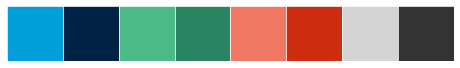

In [143]:
wbg_cat_pal = ["#009fda", '#002245', '#4cbb88', '#288462', '#f07761', '#cd2c0f', '#d4d4d4', '#333333']
sns.palplot(sns.color_palette(wbg_cat_pal))
sns.set_palette(wbg_cat_pal)

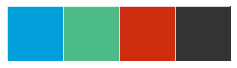

In [147]:
wbg_cat_pal2 = ["#009fda", '#4cbb88', '#cd2c0f', '#333333']
sns.palplot(sns.color_palette(wbg_cat_pal2))
sns.set_palette(wbg_cat_pal2)

# Data Preprocessing
## Loading Metadata

In [26]:
tc_datasets = 'http://tcdata360-backend.worldbank.org/api/v1/datasets'
df_tc_datasets = pd.read_json(requests.get(tc_datasets).text)

In [27]:
df_tc_datasets.head()

description   id                                              legal  \
0          NaN  590  For use guidelines, please consult PEFA (https...   
1          NaN   50  For use guidelines, please consult World Bank ...   
2          NaN   53  For use guidelines, please consult World Econo...   
3          NaN   49  For use guidelines, please consult World Bank ...   
4          NaN  747  For use guidelines, please consult World Bank ...   

                                                link  \
0               https://pefa.org/assessments/listing   
1                           http://lpi.worldbank.org   
2  http://reports.weforum.org/global-competitiven...   
3                   http://www.enterprisesurveys.org   
4   https://data.worldbank.org/data-catalog/ed-stats   

                           slug  \
0                          PEFA   
1   logistics_performance_index   
2  global_competitiveness_index   
3            enterprise_surveys   
4               WBG-genderstats   

                                              source  \
0                                               PEFA   
1                  WBG - Logistics Performance Index   
2  World Economic Forum Global Competitiveness Index   
3                           WBG - Enterprise Surveys   
4                            WBG - Gender Statistics   

                                               title  
0                                               PEFA  
1                        Logistics Performance Index  
2  World Economic Forum Global Competitiveness Index  
3                                 Enterprise Surveys  
4                                  Gender Statistics

In [120]:
df_tc_countries = pd.read_json(requests.get('http://tcdata360-backend.worldbank.org/api/v1/countries').text)

In [127]:
# fixing Argentina (incomeLevel should be UMC)
df_tc_countries.loc[df_tc_countries['iso3'] == 'ARG','incomeLevel']='UMC'

In [128]:
df_tc_countries[df_tc_countries['iso3'] == 'ARG']

adminRegion  aggregate   capitalCity                                 geo  \
7        None      False  Buenos Aires  {'lat': -34.6118, 'lng': -58.4173}   

    id incomeLevel iso2 iso3  landlocked lendingType       name region  sids  
7  ARG         UMC   AR  ARG         0.0         IBD  Argentina    LCN   0.0

## Normalizing Time data
For efficiency, we choose to normalize the data per dataset (instead of per country) since intra-dataset time periods are usually consistent.

### Defining Functions

In [78]:
# def normalize_dates(list_dates):
#     normed_dates = []
#     for x in list_dates:
#         cleaned_date = x
#         # for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
#         m = re.match('(\d{4})-(\d{4})', str(x))
#         if m:
#             cleaned_date = m.groups()[-1]
#         else: #for simplicity, we remap monthly/quarterly dates
#             n = re.match('(\d{4})Q\d{1}', str(x))
#             if n:
#                 cleaned_date = n.groups()[-1]
#             else:
#                 o = re.match('(\d{4})M\d{2}', str(x))
#                 if o:
#                     cleaned_date = o.groups()[-1]
#         normed_dates.append(cleaned_date)
#     return normed_dates

In [131]:
def normalize_dates(list_dates):
    normed_dates = []
    not_normed_list = []
    not_normed = False
    
    for x in list_dates:
        cleaned_date = x
        
        # for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
        m = re.match('(\d{4})-(\d{4})', str(x))
        m2 = re.match('(\d{4})-(\d{2})', str(x))
        if m:
            cleaned_date = m.groups()[0]
            not_normed = False
            
        elif m2:
            cleaned_date = m2.groups()[0]
            not_normed = False
                
        else: #for simplicity, we remap monthly/quarterly dates
            n = re.match('(\d{4})Q\d{1}', str(x))
            if n:
                cleaned_date = n.groups()[-1]
                not_normed = True
            else:
                o = re.match('(\d{4})M\d{2}', str(x))
                if o:
                    cleaned_date = o.groups()[-1]
                    not_normed = True
                    
        normed_dates.append(cleaned_date)
        not_normed_list.append(not_normed)
    return normed_dates, not_normed_list, sum(not_normed_list)

In [132]:
normalize_dates(['2011Q1', '2011-2012', '2013-14'])

(['2011', '2011', '2013'], [True, False, False], 1)

### Preprocess dataset (normalized time periods)
Assumptions for data preprocessing:
- for period dates, we get the earlier date (e.g., 2008-2009 -- we use 2008)
- for simplicity, we get the mean presence of monthly/quarterly dates (e.g., if only 1 of 4 quarterly data is available for that year, that year has the value 0.25)
- we also keep indicator-levels data only. Subindicators are removed from analysis since this might bloat counts for datasets with a lot of subindicators -- for instance, Doing Business data has DTF/Rank subindicator data for each indicator.

In [133]:
df_compiled = pd.DataFrame()
success_counter = 0
error_counter = 0
error_list = []
total_count = len(df_tc_datasets.index)

for row in df_tc_datasets.index:
# row = df_tc_datasets.index[0]
    id_dataset = df_tc_datasets['id'].iloc[row]
    title_dataset = df_tc_datasets['title'].loc[row]

    try:
        dat_url = "http://tcdata360-backend.worldbank.org/api/v1/datasets/" + str(id_dataset) + "/dump.csv"
        dat = requests.get(dat_url)
        df_dat = pd.read_csv(io.StringIO(dat.text))
        df_dat.drop(['Country Name', 'Subindicator Type'], axis=1, inplace=True)

        # Group columns by type: date, and non-date
        nondate_cols = ['Country ISO3', 'Country Name', 'Indicator', 'Subindicator Type', 'Partner', 'MRV', 'Product']
        list_nondate = [col for col in df_dat.columns if col in nondate_cols]
        list_timeframe = [col for col in df_dat.columns if col not in nondate_cols]

        #Convert date columns to boolean
        df_dat[list_timeframe] = df_dat[list_timeframe].notnull().replace({True:1.0, False:0.0})

        normed_dates, not_normed_list, not_normed = normalize_dates(list_timeframe)

        if not_normed > 0:
            df_temp = df_dat[list_nondate]

            # collate all possible dates
            pat = '(\d{4})Q\d{1}'
            df_grouped = df_dat.groupby(df_dat.columns.str.extract(pat, expand=False), axis=1)
            if bool(df_grouped.groups):
                for group in df_grouped.groups.keys():
                    df_temp[group] = df_grouped.get_group(group).mean(axis=1)
            else:
                pat = '(\d{4})M\d{2}'
                df_grouped = df_dat.groupby(df_dat.columns.str.extract(pat, expand=False), axis=1)
                if bool(df_grouped.groups):
                    for group in df_grouped.groups.keys():
                        df_temp[group] = df_grouped.get_group(group).mean(axis=1)
        else:
            df_temp = df_dat
            new_cols = list_nondate + list_timeframe
            df_temp = df_temp[new_cols]
            df_temp.columns = list_nondate + normed_dates

        df_temp['dataset_id'] = id_dataset
        df_compiled = df_compiled.append(df_temp)
    
        success_counter += 1
        print("Done checking %d out of %d datasets." % (success_counter + error_counter, total_count))

    except:
        error_counter += 1
        error_list.append([title_dataset, id_dataset])
        continue

print("Done with all %d datasets with %d successes and %d failures." % (total_count, success_counter, error_counter))
print("Failed datasets include %s" % str(error_list))

Done checking 1 out of 76 datasets.
Done checking 2 out of 76 datasets.
Done checking 3 out of 76 datasets.
Done checking 4 out of 76 datasets.
Done checking 5 out of 76 datasets.
Done checking 6 out of 76 datasets.
Done checking 7 out of 76 datasets.
Done checking 8 out of 76 datasets.
Done checking 9 out of 76 datasets.
Done checking 10 out of 76 datasets.
Done checking 11 out of 76 datasets.


C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done checking 12 out of 76 datasets.
Done checking 13 out of 76 datasets.
Done checking 14 out of 76 datasets.
Done checking 15 out of 76 datasets.
Done checking 16 out of 76 datasets.
Done checking 17 out of 76 datasets.


C:\Users\mrpso\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done checking 18 out of 76 datasets.
Done checking 19 out of 76 datasets.
Done checking 20 out of 76 datasets.
Done checking 21 out of 76 datasets.
Done checking 22 out of 76 datasets.
Done checking 23 out of 76 datasets.
Done checking 24 out of 76 datasets.
Done checking 25 out of 76 datasets.
Done checking 26 out of 76 datasets.
Done checking 27 out of 76 datasets.
Done checking 28 out of 76 datasets.
Done checking 29 out of 76 datasets.
Done checking 30 out of 76 datasets.
Done checking 31 out of 76 datasets.
Done checking 32 out of 76 datasets.
Done checking 33 out of 76 datasets.
Done checking 34 out of 76 datasets.
Done checking 35 out of 76 datasets.
Done checking 36 out of 76 datasets.
Done checking 37 out of 76 datasets.
Done checking 38 out of 76 datasets.
Done checking 39 out of 76 datasets.
Done checking 41 out of 76 datasets.
Done checking 42 out of 76 datasets.
Done checking 44 out of 76 datasets.
Done checking 45 out of 76 datasets.
Done checking 46 out of 76 datasets.
D

In [134]:
df_compiled.shape

(1204953, 115)

In [135]:
df_compiled.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928     ...      \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       

   2024  2025  2026  2027  Country ISO3  \
0   NaN   NaN   NaN   NaN           ABW   
1   NaN   NaN   NaN   NaN           ABW   
2   NaN   NaN   NaN   NaN           ABW   
3   NaN   NaN   NaN   NaN           ABW   
4   NaN   NaN   NaN   NaN           AFG   

                                           Indicator  MRV  Partner  Product  \
0  i Annual deviation of actual total HLG transfe...  NaN      NaN      NaN   
1  ii Annual variance between actual and estimate...  NaN      NaN      NaN   
2  iii Inyear timeliness of transfers from HLG co...  NaN      NaN      NaN   
3  Predictability of Transfers from Higher Level ...  NaN      NaN      NaN   
4  Aggregate expenditure outturn compared to orig...  NaN      NaN      NaN   

   dataset_id  
0         590  
1         590  
2         590  
3         590  
4         590  

[5 rows x 115 columns]

In [136]:
df_compiled.columns

Index(['1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927',
       '1928',
       ...
       '2024', '2025', '2026', '2027', 'Country ISO3', 'Indicator', 'MRV',
       'Partner', 'Product', 'dataset_id'],
      dtype='object', length=115)

In [5]:
nondate_cols = ['Country ISO3', 'Country Name', 'Indicator', 'Subindicator Type', 'Partner', 'MRV', 'Product']
nondate_cols_all = nondate_cols + ['dataset_id']
list_nondate_all = [col for col in df_compiled.columns if col in nondate_cols_all]
list_timeframe_all = [col for col in df_compiled.columns if col not in nondate_cols_all]

In [6]:
list_timeframe_all

['1919',
 '1920',
 '1921',
 '1922',
 '1923',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025',
 '2026',
 '2027']

In [149]:
df_compiled.reset_index(drop=True, inplace=True)

In [ ]:
df_compiled.to_csv("2017-08-05-TCdataset-complete.csv", index=False)

### Post-compilation Processing
- fill NA with 0
- drop duplicates (keep indicator-level data only)
- map indicators to Indicator ID
- map indicators to topics (we keep first hierarchy only)

In [7]:
df_compiled = pd.read_csv("2017-08-05-TCdataset-complete.csv")

C:\Users\mrpso\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_compiled[list_timeframe_all] = df_compiled[list_timeframe_all].replace({np.nan: 0.0})

In [9]:
df_compiled.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928     ...      \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     ...       

   2024  2025  2026  2027  Country ISO3  \
0   0.0   0.0   0.0   0.0           ABW   
1   0.0   0.0   0.0   0.0           ABW   
2   0.0   0.0   0.0   0.0           ABW   
3   0.0   0.0   0.0   0.0           ABW   
4   0.0   0.0   0.0   0.0           AFG   

                                           Indicator  MRV  Partner  Product  \
0  i Annual deviation of actual total HLG transfe...  NaN      NaN      NaN   
1  ii Annual variance between actual and estimate...  NaN      NaN      NaN   
2  iii Inyear timeliness of transfers from HLG co...  NaN      NaN      NaN   
3  Predictability of Transfers from Higher Level ...  NaN      NaN      NaN   
4  Aggregate expenditure outturn compared to orig...  NaN      NaN      NaN   

   dataset_id  
0         590  
1         590  
2         590  
3         590  
4         590  

[5 rows x 115 columns]

In [10]:
df_compiled.drop_duplicates(inplace=True)

#### Merging Indicator and Nav lists for TC

In [11]:
df_tc_indicators = pd.read_json(requests.get('http://tcdata360-backend.worldbank.org/api/v1/indicators').text)
df_tc_indicators = df_tc_indicators[['datasetId', 'name', 'id']]
df_tc_indicators.drop_duplicates(subset=['datasetId', 'name'], inplace=True)

In [14]:
df_tc_nav = pd.read_csv("2017-08-07-TC-hierarchy.csv")
df_tc_nav = df_tc_nav.drop_duplicates(subset=['indicator.name'])[['indicator.name', 'level0.name','level1.name']]

In [47]:
df_tc_nav['name-lookup'] = df_tc_nav['indicator.name'].apply(lambda x: x.lower().strip())
df_tc_indicators['name-lookup'] = df_tc_indicators['name'].apply(lambda x: x.lower().strip())

In [48]:
df_tc_ind_nav = df_tc_indicators.merge(df_tc_nav, how='left', on='name-lookup')

#### Merging Indicator and Nav lists for Gov

In [40]:
df_gv_indicators = pd.read_json(requests.get('http://govdata360-backend.worldbank.org/api/v1/indicators').text)
df_gv_indicators = df_gv_indicators[['datasetId', 'name', 'id']]
df_gv_indicators.drop_duplicates(subset=['datasetId', 'name'], inplace=True)

In [41]:
df_gv_nav = pd.read_csv("2017-08-07-Gov-hierarchy.csv")
df_gv_nav = df_gv_nav.drop_duplicates(subset=['indicator.name'])[['indicator.name', 'level0.name','level1.name']]

In [49]:
df_gv_nav['name-lookup'] = df_gv_nav['indicator.name'].apply(lambda x: x.lower().strip())
df_gv_indicators['name-lookup'] = df_gv_indicators['name'].apply(lambda x: x.lower().strip())

In [51]:
df_gv_ind_nav = df_gv_indicators.merge(df_gv_nav, how='left', on='name-lookup')

In [52]:
df_ind_nav = pd.concat([df_tc_ind_nav, df_gv_ind_nav], axis=0).reset_index(drop=True)

In [53]:
df_ind_nav.to_csv("2017-08-07-TCGov-ind-hierarchy-merged.csv", index=False)

Import manually cleaned merged hierarchy-indicator list for TC and Gov

In [54]:
df_ind_nav = pd.read_csv("2017-08-07-TCGov-ind-hierarchy-merged-complete.csv")

In [60]:
df_ind_nav.columns = ['datasetId', 'name', 'indicatorId', 'name-lookup', 'indicator.name','topiclvl1', 'topiclvl2']

In [61]:
df_merged = df_compiled.merge(df_ind_nav, how='left', left_on=['dataset_id', 'Indicator'], right_on=['datasetId', 'name'])

In [68]:
df_merged = df_merged[df_merged['name'].notnull()]

In [70]:
df_merged[df_merged['indicator.name'].isnull()]

Empty DataFrame
Columns: [1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, ...]
Index: []

[0 rows x 122 columns]

#### Removing product- and partner-level indicators

In [213]:
df_merged.shape

(989910, 117)

In [215]:
df_merged.drop_duplicates(subset=['dataset_id', 'indicatorId', 'Country ISO3']).shape

(461127, 117)

In [216]:
df_merged2 = df_merged.drop_duplicates(subset=['dataset_id', 'indicatorId', 'Country ISO3'])

In [221]:
df_merged2.groupby('Country ISO3')['dataset_id'].value_counts().unstack(level=-1)

dataset_id     44   45    46    47     48     49   50   51    52     53   \
Country ISO3                                                               
ABW            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
AFG            2.0  3.0   NaN  22.0  112.0  121.0  7.0  6.0  65.0    NaN   
AGO            NaN  3.0   NaN  22.0  116.0  120.0  7.0  6.0  64.0  120.0   
ALB            4.0  3.0   NaN  23.0  112.0  121.0  7.0  6.0  65.0  120.0   
AND            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
ARE            4.0  3.0   NaN   NaN  118.0    NaN  7.0  6.0  65.0  119.0   
ARG           10.0  3.0   4.0  23.0  117.0  119.0  7.0  6.0  65.0  120.0   
ARM            6.0  3.0   NaN  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
ASM            NaN  NaN   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
ATG            1.0  3.0   NaN   NaN  110.0  103.0  NaN  6.0  65.0    NaN   
AUS           13.0  3.0  15.0   NaN  115.0    NaN  7.0  6.0  65.0  120.0   
AUT            2.0  3.0  19.0  23.0  116.0    NaN  7.0  6.0  65.0  120.0   
AZE            1.0  3.0   NaN  23.0  118.0  121.0  7.0  6.0  65.0  120.0   
BDI            3.0  3.0   NaN   NaN  120.0  121.0  7.0  6.0  65.0  119.0   
BEL            2.0  3.0  17.0   NaN  121.0    NaN  7.0  6.0  65.0  120.0   
BEN            3.0  3.0   NaN   NaN  117.0  120.0  7.0  6.0  65.0  120.0   
BFA            1.0  3.0   NaN  21.0  118.0  120.0  7.0  6.0  65.0  120.0   
BGD            NaN  3.0   NaN  23.0  118.0  121.0  7.0  6.0  59.0  120.0   
BGR            6.0  3.0   3.0  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
BHR            5.0  3.0   NaN   NaN  123.0    NaN  7.0  6.0  65.0  119.0   
BHS            NaN  3.0   NaN   NaN  107.0  107.0  7.0  6.0  65.0    NaN   
BIH            NaN  3.0   NaN  22.0  119.0  121.0  7.0  6.0  65.0  120.0   
BLR            NaN  3.0   NaN  23.0  115.0  121.0  7.0  6.0  65.0    NaN   
BLZ            2.0  3.0   NaN   NaN  108.0  105.0  NaN  6.0  65.0  112.0   
BMU            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
BOL            3.0  3.0   NaN  23.0  115.0  119.0  7.0  6.0  65.0  120.0   
BRA           12.0  3.0   8.0  23.0  118.0  119.0  7.0  6.0  59.0  120.0   
BRB            5.0  3.0   NaN   NaN  107.0  106.0  NaN  6.0  65.0  119.0   
BRN            3.0  3.0   NaN   NaN  111.0    NaN  7.0  6.0  65.0  120.0   
BTN            NaN  3.0   NaN   NaN  111.0  121.0  7.0  6.0  64.0  119.0   
...            ...  ...   ...   ...    ...    ...  ...  ...   ...    ...   
SYR            NaN  3.0   NaN   NaN  120.0  105.0  7.0  6.0  65.0  114.0   
TCA            NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN   NaN    NaN   
TCD            NaN  3.0   NaN   NaN  121.0  108.0  7.0  6.0  65.0  119.0   
TGO            3.0  3.0   NaN   NaN  119.0  120.0  7.0  6.0  65.0    NaN   
THA           11.0  3.0   NaN  23.0  113.0  119.0  7.0  6.0  65.0  120.0   
TJK            1.0  3.0   NaN   NaN  119.0  121.0  7.0  6.0  65.0  120.0   
TKM            NaN  3.0   NaN   NaN    NaN    NaN  7.0  6.0   NaN    NaN   
TLS            NaN  3.0   NaN   NaN  114.0  120.0  6.0  6.0  64.0  119.0   
TON            NaN  3.0   NaN   NaN  108.0  106.0  NaN  6.0  65.0    NaN   
TTO            5.0  3.0   NaN   NaN  113.0  119.0  7.0  6.0  65.0  119.0   
TUN            5.0  3.0   NaN  23.0  118.0  121.0  7.0  6.0  65.0  120.0   
TUR           13.0  3.0  16.0  23.0  112.0  121.0  7.0  6.0  65.0  120.0   
TUV            NaN  3.0   NaN   NaN    NaN    NaN  NaN  6.0   NaN    NaN   
TZA            3.0  3.0   NaN  22.0  114.0  121.0  7.0  6.0  65.0  120.0   
UGA            3.0  3.0   NaN  22.0  119.0  121.0  7.0  6.0  65.0  120.0   
UKR           12.0  3.0   NaN  23.0  119.0  121.0  7.0  6.0  65.0  120.0   
URY            9.0  3.0   NaN   NaN  116.0  119.0  7.0  6.0  65.0  120.0   
USA           15.0  3.0  18.0  23.0  113.0    NaN  7.0  6.0  59.0  120.0   
UZB            NaN  3.0   NaN   NaN  119.0  121.0  7.0  6.0  65.0    NaN   
VCT            3.0  3.0   NaN   NaN  110.0  107.

In [222]:
df_merged2.drop(['Partner', 'Product'], axis=1, inplace=True)

C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [224]:
df_merged2.reset_index(drop=True, inplace=True)

### Export as CSV, HDF5 files

In [71]:
df_merged.to_csv("2017-08-05-TCdataset-deduped-mapped-verbose.csv", index=False)

In [72]:
df_merged.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...                Partner  Product  dataset_id  datasetId  \
0              ...                    NaN      NaN         590      590.0   
1              ...                    NaN      NaN         590      590.0   
2              ...                    NaN      NaN         590      590.0   
3              ...                    NaN      NaN         590      590.0   
4              ...                    NaN      NaN         590      590.0   

                                                name  indicatorId  \
0  i Annual deviation of actual total HLG transfe...      27373.0   
1  ii Annual variance between actual and estimate...      27406.0   
2  iii Inyear timeliness of transfers from HLG co...      27336.0   
3  Predictability of Transfers from Higher Level ...      27358.0   
4  Aggregate expenditure outturn compared to orig...      27333.0   

                                         name-lookup  \
0  i annual deviation of actual total hlg transfe...   
1  ii annual variance between actual and estimate...   
2  iii inyear timeliness of transfers from hlg co...   
3  predictability of transfers from higher level ...   
4  aggregate expenditure outturn compared to orig...   

                                      indicator.name  \
0  i Annual deviation of actual total HLG transfe...   
1  ii Annual variance between actual and estimate...   
2  iii Inyear timeliness of transfers from HLG co...   
3  Predictability of Transfers from Higher Level ...   
4  Aggregate expenditure outturn compared to orig...   

                  topiclvl1                      topiclvl2  
0  Public Sector Management  Public Expenditure Management  
1  Public Sector Management  Public Expenditure Management  
2  Public Sector Management  Public Expenditure Management  
3  Public Sector Management  Public Expenditure Management  
4  Public Sector Management  Public Expenditure Management  

[5 rows x 122 columns]

In [74]:
df_merged.drop(['name-lookup','indicator.name', 'name','datasetId', 'Indicator'], axis=1,inplace=True)

In [85]:
df_merged.head()

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...                2026  2027  Country ISO3  MRV  Partner  \
0              ...                 0.0   0.0           ABW  NaN      NaN   
1              ...                 0.0   0.0           ABW  NaN      NaN   
2              ...                 0.0   0.0           ABW  NaN      NaN   
3              ...                 0.0   0.0           ABW  NaN      NaN   
4              ...                 0.0   0.0           AFG  NaN      NaN   

   Product  dataset_id  indicatorId                 topiclvl1  \
0      NaN         590      27373.0  Public Sector Management   
1      NaN         590      27406.0  Public Sector Management   
2      NaN         590      27336.0  Public Sector Management   
3      NaN         590      27358.0  Public Sector Management   
4      NaN         590      27333.0  Public Sector Management   

                       topiclvl2  
0  Public Expenditure Management  
1  Public Expenditure Management  
2  Public Expenditure Management  
3  Public Expenditure Management  
4  Public Expenditure Management  

[5 rows x 117 columns]

In [86]:
df_merged.to_csv("2017-08-05-TCdataset-deduped-mapped.csv", index=False)

In [225]:
df_merged2.to_csv("2017-08-05-TCdataset-deduped-mapped-final.csv", index=False)

In [237]:
store = pd.HDFStore('TCdatacensusdata.h5')

In [238]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: TCdatacensusdata.h5
/df_tcdata                          frame_table  (typ->appendable,nrows->1204953,ncols->115,indexers->[index])
/df_tcdata_cleaned                  frame_table  (typ->appendable,nrows->989910,ncols->117,indexers->[index]) 
/df_tcdata_cleaned_final            frame_table  (typ->appendable,nrows->461127,ncols->115,indexers->[index]) 

In [239]:
store.is_open

True

In [231]:
df_merged2.to_hdf('TCdatacensusdata.h5', 'df_tcdata_cleaned_final', format = 'table')

In [240]:
store.close()

# More Processing: Filtering Timeframes and Topics

In [6]:
df_merged2 = pd.read_csv("2017-08-05-TCdataset-deduped-mapped-final.csv")

## Keep only T&C Topics: Trade, Innovation, Sectors, Investment

In [7]:
df_merged2 = df_merged2[df_merged2['topiclvl1'].isin(['Trade', 'Innovation', 'Sectors','Investment'])]

In [8]:
df_merged2['topiclvl1'].value_counts()

Investment    75368
Trade         72332
Innovation    20650
Sectors       13664
Name: topiclvl1, dtype: int64

In [9]:
df_merged2.columns

Index(['1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927',
       '1928',
       ...
       '2024', '2025', '2026', '2027', 'Country ISO3', 'MRV', 'dataset_id',
       'indicatorId', 'topiclvl1', 'topiclvl2'],
      dtype='object', length=115)

## Drop irrelevant timeframes
- NULL timeframes: 1919-1954
- Incomplete/projected timeframes: 2017-2027

In [10]:
df_merged2.shape

(182014, 115)

In [11]:
check_sums = df_merged2.describe().T

In [17]:
check_sums[(check_sums['mean'] == 0) & (check_sums['max'] == 0)]

count  mean  std  min  25%  50%  75%  max
1919  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1920  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1921  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1922  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1923  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1924  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1925  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1926  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1927  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1928  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1929  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1930  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1931  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1932  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1933  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1934  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1935  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1936  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1937  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1938  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1939  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1940  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1941  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1942  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1943  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1944  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1945  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1946  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1947  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1948  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1949  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1950  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1951  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1952  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1953  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1954  182014.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [26]:
check_sums.loc['2017':'MRV']

count       mean        std  min       25%       50%        75%  \
2017  182014.0   0.040997   0.198283  0.0  0.000000  0.000000   0.000000   
2018  182014.0   0.013510   0.115445  0.0  0.000000  0.000000   0.000000   
2019  182014.0   0.013510   0.115445  0.0  0.000000  0.000000   0.000000   
2020  182014.0   0.013510   0.115445  0.0  0.000000  0.000000   0.000000   
2021  182014.0   0.013510   0.115445  0.0  0.000000  0.000000   0.000000   
2022  182014.0   0.013510   0.115445  0.0  0.000000  0.000000   0.000000   
2023  182014.0   0.011604   0.107093  0.0  0.000000  0.000000   0.000000   
2024  182014.0   0.011604   0.107093  0.0  0.000000  0.000000   0.000000   
2025  182014.0   0.011604   0.107093  0.0  0.000000  0.000000   0.000000   
2026  182014.0   0.011604   0.107093  0.0  0.000000  0.000000   0.000000   
2027  182014.0   0.011604   0.107093  0.0  0.000000  0.000000   0.000000   
MRV      594.0  20.091126  24.373109  0.0  2.458602  9.300337  29.678695   

          max  
2017   1.0000  
2018   1.0000  
2019   1.0000  
2020   1.0000  
2021   1.0000  
2022   1.0000  
2023   1.0000  
2024   1.0000  
2025   1.0000  
2026   1.0000  
2027   1.0000  
MRV   98.6318

In [12]:
drop_timeframes = list(check_sums[(check_sums['mean'] == 0) & (check_sums['max'] == 0)].index) + list(check_sums.loc['2017':'MRV'].index)

In [13]:
df_merged2.drop(drop_timeframes, axis=1, inplace=True)

## Checks and Generate handy lists

In [14]:
nondate_cols_all = ['Country ISO3','dataset_id','indicatorId', 'topiclvl1', 'topiclvl2']
list_timeframe_all = [col for col in df_merged2.columns if col not in nondate_cols_all]

In [15]:
df_merged2.columns

Index(['1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963',
       '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       'Country ISO3', 'dataset_id', 'indicatorId', 'topiclvl1', 'topiclvl2'],
      dtype='object')

In [16]:
df_merged2[['indicatorId', 'Country ISO3', 'dataset_id']].duplicated().sum()

0

In [17]:
df_merged2.to_csv("2017-08-31-TCdataset-narrowtopics.csv", index=False)

# Country-level Data Analysis

In [ ]:
df_merged2 = pd.read_csv("2017-08-31-TCdataset-narrowtopics.csv")

In [129]:
total_indicators = len(df_merged2['indicatorId'].unique())

In [130]:
total_indicators

1374

In [131]:
by_country = df_merged2.groupby('Country ISO3')[list_timeframe_all].sum()/total_indicators

In [132]:
by_country.head()

1955  1956  1957  1958  1959      1960      1961      1962  \
Country ISO3                                                               
ABW            0.0   0.0   0.0   0.0   0.0  0.000728  0.000000  0.000000   
AFG            0.0   0.0   0.0   0.0   0.0  0.015284  0.013828  0.019651   
AGO            0.0   0.0   0.0   0.0   0.0  0.014556  0.013100  0.020378   
ALB            0.0   0.0   0.0   0.0   0.0  0.003639  0.002183  0.002183   
AND            0.0   0.0   0.0   0.0   0.0  0.000728  0.000000  0.000000   

                  1963      1964    ...         2007      2008      2009  \
Country ISO3                        ...                                    
ABW           0.000000  0.000000    ...     0.095342  0.093886  0.105531   
AFG           0.019651  0.025473    ...     0.109170  0.233624  0.141557   
AGO           0.013100  0.013100    ...     0.137555  0.152111  0.156477   
ALB           0.002183  0.002183    ...     0.349345  0.278748  0.283115   
AND           0.000000  0.000000    ...     0.036390  0.036390  0.036390   

                  2010      2011      2012      2013      2014      2015  \
Country ISO3                                                               
ABW           0.108443  0.122271  0.110626  0.111354  0.093886  0.104440   
AFG           0.152111  0.146288  0.181951  0.171761  0.255459  0.144469   
AGO           0.388646  0.243086  0.287482  0.286754  0.417758  0.235808   
ALB           0.327511  0.289665  0.395197  0.435226  0.438865  0.351164   
AND           0.036390  0.036390  0.036390  0.034207  0.034207  0.012373   

                  2016  
Country ISO3            
ABW           0.010917  
AFG           0.165211  
AGO           0.256186  
ALB           0.438137  
AND           0.002911  

[5 rows x 62 columns]

In [133]:
df_tc_countries.set_index('id', inplace=True)

In [134]:
by_country = by_country.join(df_tc_countries[['region', 'incomeLevel', 'lendingType']], how='left')

## Timeseries Plots

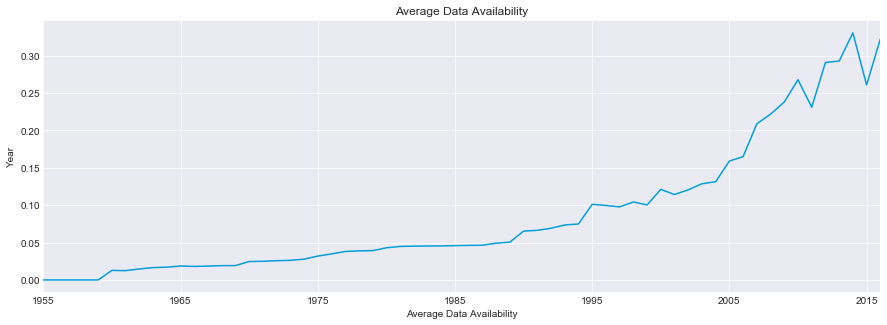

In [135]:
plt.title("Average Data Availability")
plt.ylabel("Year")
plt.xlabel("Average Data Availability")
by_country[list_timeframe_all].mean(axis=0).plot(figsize=(15,5))

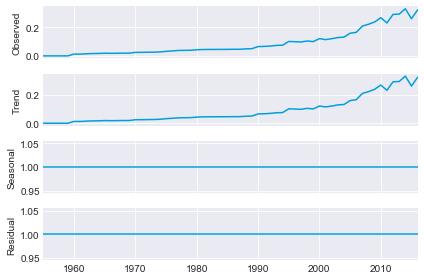

In [31]:
dat = pd.DataFrame(by_country[list_timeframe_all].mean(axis=0))
dat.index = pd.to_datetime(dat.index)
res = sm.tsa.seasonal_decompose(dat[0],model='multiplicative')
resplot = res.plot()

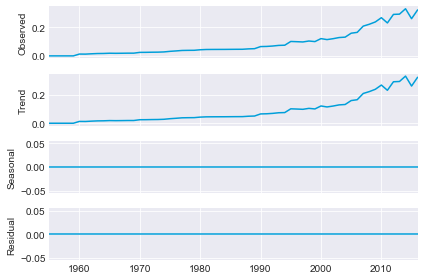

In [32]:
res = sm.tsa.seasonal_decompose(dat[0],model='additive')
resplot = res.plot()

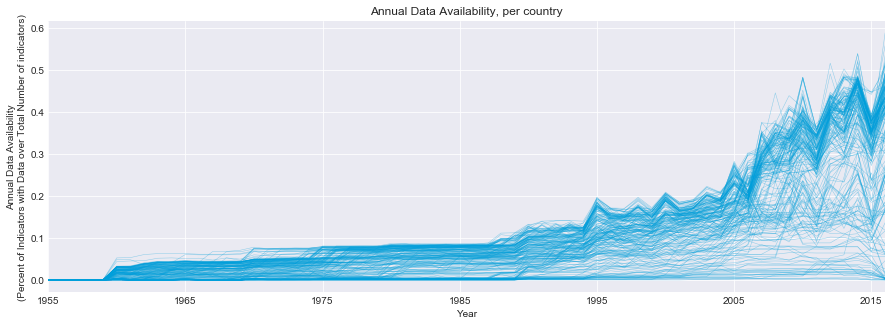

In [33]:
by_country[list_timeframe_all].T.plot(color='#009fda', lw=0.5, alpha=0.4, figsize=(15,5))
plt.title("Annual Data Availability, per country")
plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
plt.xlabel("Year")
plt.legend([])

In [34]:
by_country_melt.head()

NameError: name 'by_country_melt' is not defined

### By Condition

In [151]:
def tsplot_bycond(by_country_melt, cond):
    plt.figure(figsize=(15,5))
    sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond,err_style='unit_traces', err_kws = {'alpha': 0.05})
    plt.title("Annual Data Availability, per country, per %s\n(Mean Estimator)" % (cond))
    plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
    plt.xlabel("Year")
    plt.show()
    
    plt.figure(figsize=(15,5))
    sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond, err_style='ci_band', ci=[0,100], err_kws = {'alpha': 0.05})
    plt.title("Annual Data Availability, per country, per %s\n(Mean Estimator)" % (cond))
    plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
    plt.xlabel("Year")
    plt.show()
    
    plt.figure(figsize=(15,5))
    sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = cond, err_style='ci_band', ci=[0,100], estimator=np.median, err_kws = {'alpha': 0.05})
    plt.title("Annual Data Availability, per country, per %s\n(Median estimator)" % (cond))
    plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
    plt.xlabel("Year")
    plt.show()

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



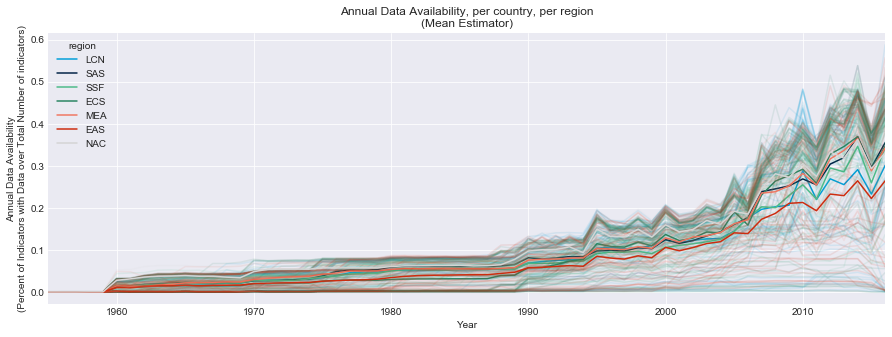

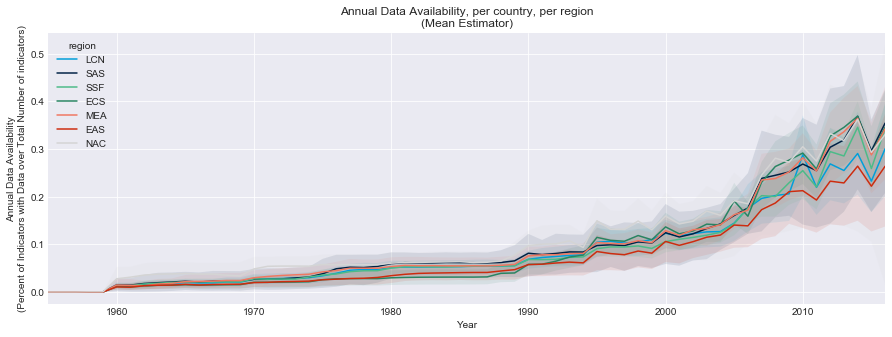

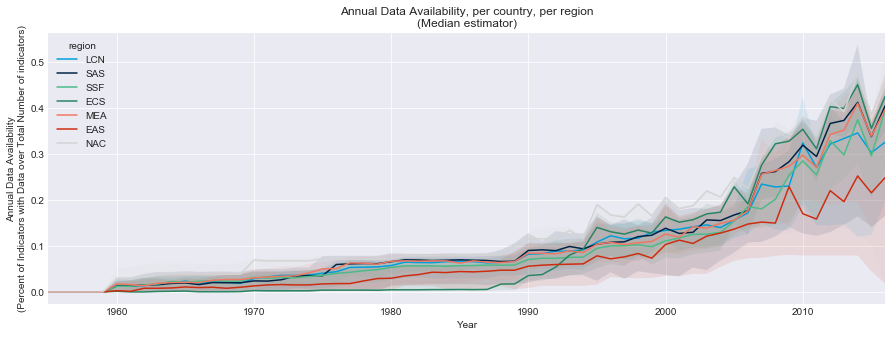

In [125]:
tsplot_bycond(by_country_melt, cond='region')

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



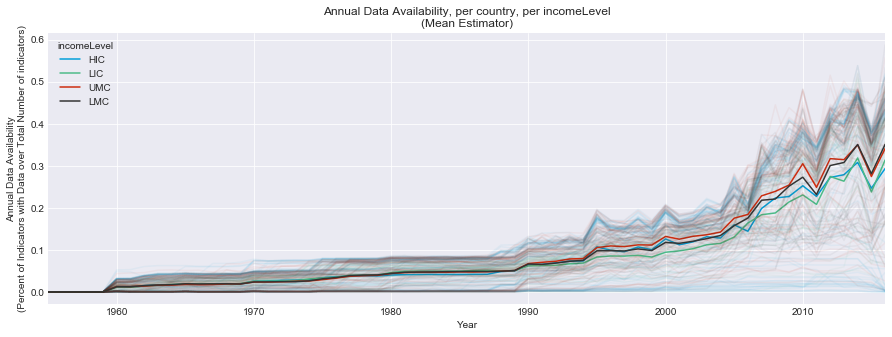

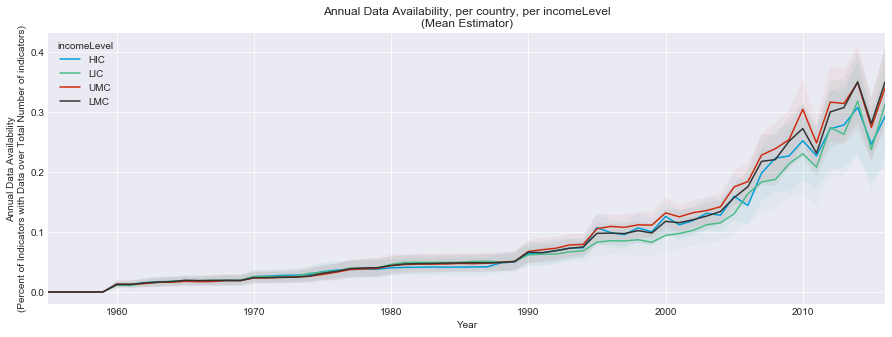

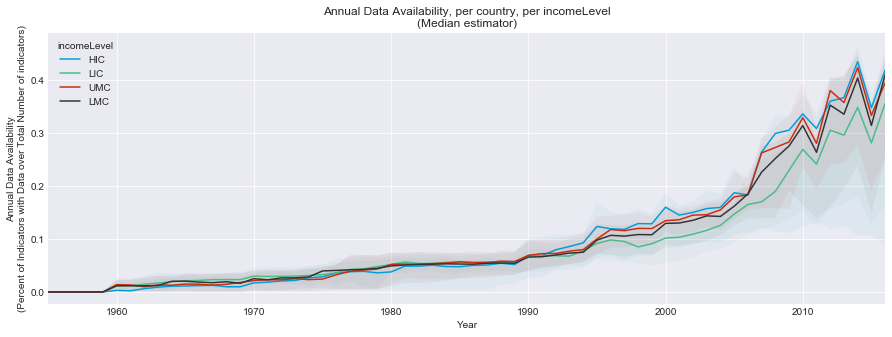

In [152]:
tsplot_bycond(by_country_melt, cond='incomeLevel')

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



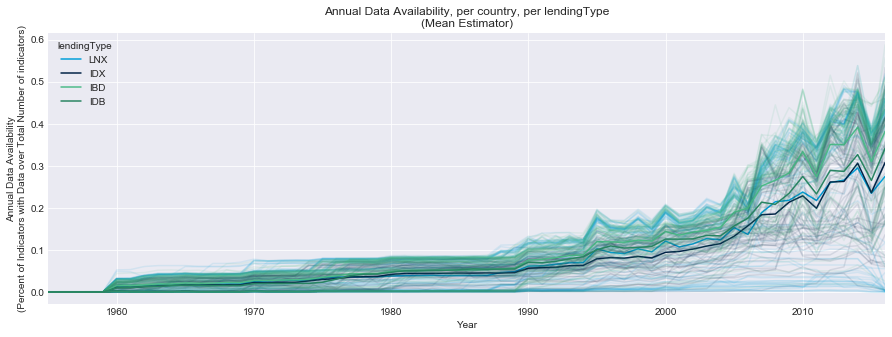

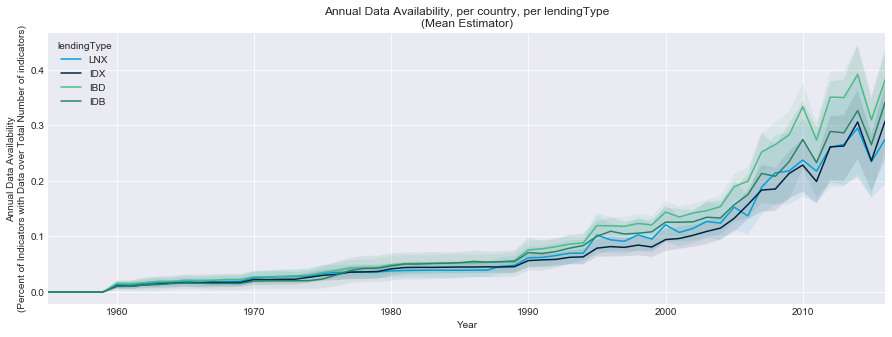

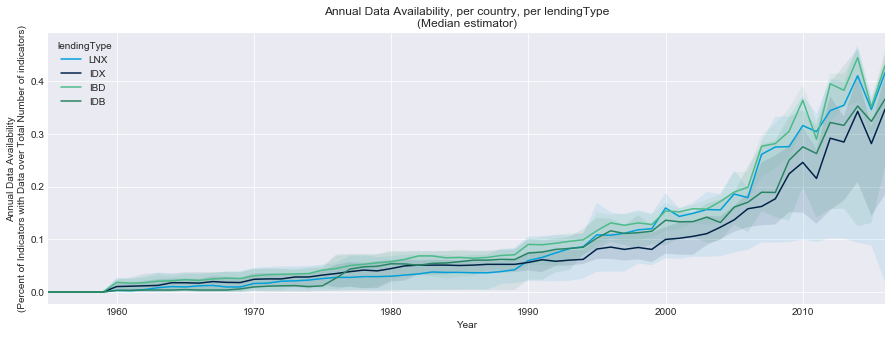

In [127]:
tsplot_bycond(by_country_melt, cond='lendingType')

In [420]:
by_country[by_country['incomeLevel'] == 'INX']

1919  1920  1921  1922  1923  1924  1925  1926  1927  1928  \
Country ISO3                                                               
ARG            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               ...        2022     2023     2024     2025     2026     2027  \
Country ISO3   ...                                                            
ARG            ...     0.00525  0.00252  0.00252  0.00252  0.00252  0.00252   

              region  incomeLevel  lendingType  cluster  
Country ISO3                                             
ARG              LCN          INX          IBD        2  

[1 rows x 113 columns]

## Histograms

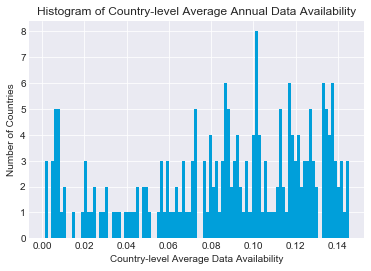

In [134]:
plt.title("Histogram of Country-level Average Annual Data Availability")
plt.ylabel("Number of Countries")
plt.xlabel("Country-level Average Data Availability")
map_by_country['ave_data_avail'].hist(bins=100)

In [135]:
by_country_melt.head()

Country ISO3 region incomeLevel lendingType  cluster Period  Observation
0          ABW    LCN         HIC         LNX        3   1955          0.0
1          AFG    SAS         LIC         IDX        3   1955          0.0
2          AGO    SSF         UMC         IBD        3   1955          0.0
3          ALB    ECS         UMC         IBD        3   1955          0.0
4          AND    ECS         HIC         LNX        3   1955          0.0

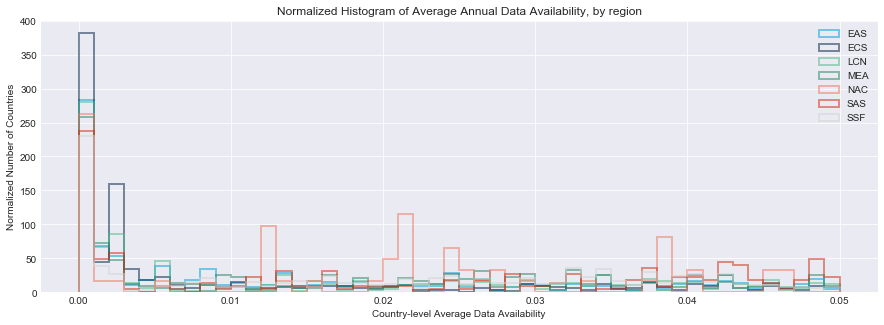

In [136]:
cond = 'region'
fig, ax = plt.subplots(figsize=(15,5))
df_grouped = by_country_melt.groupby(cond)[['Period', 'Observation']]
for label, group in df_grouped:
    group[['Period', 'Observation']].hist(bins = np.arange(0,0.051, 0.001), histtype='step', label = label, ax=ax, alpha=0.5, lw=2, normed=True)
plt.legend()
plt.title("Normalized Histogram of Average Annual Data Availability, by region")
plt.ylabel("Normalized Number of Countries")
plt.xlabel("Country-level Average Data Availability")
plt.show()

## Barplots

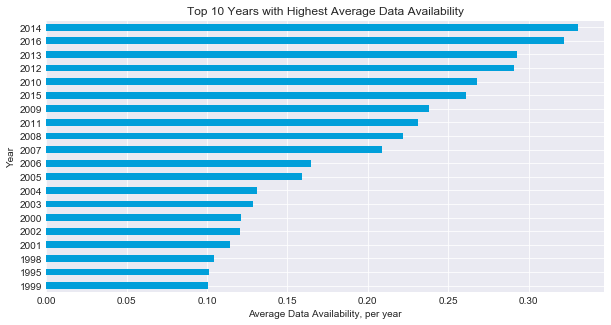

In [45]:
plt.title("Top 10 Years with Highest Average Data Availability")
plt.ylabel("Year")
plt.xlabel("Average Data Availability, per year")
by_country[list_timeframe_all].mean(axis=0).sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(10,5))

In [138]:
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=False).head(20)

Country ISO3
USA    0.145279
CAN    0.145047
COL    0.143864
BRA    0.143741
KOR    0.142241
ZAF    0.141563
MEX    0.141126
CHL    0.140483
ARG    0.139885
TUR    0.139183
IND    0.138643
SWE    0.138121
THA    0.137760
GBR    0.137663
NLD    0.137604
PHL    0.137390
FRA    0.137285
NOR    0.136665
MYS    0.136469
ISR    0.135650
dtype: float64

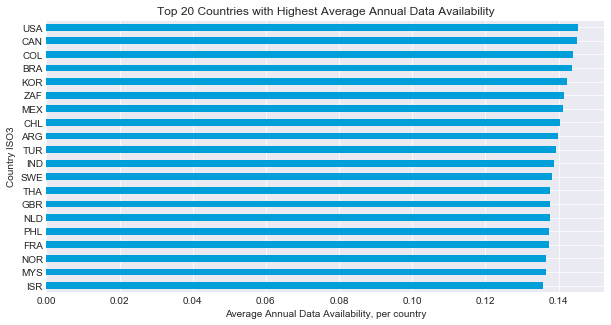

In [46]:
plt.title("Top 20 Countries with Highest Average Annual Data Availability")
plt.ylabel("Country ISO3")
plt.xlabel("Average Annual Data Availability, per country")
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=True).tail(20).plot(kind='barh', figsize=(10,5))

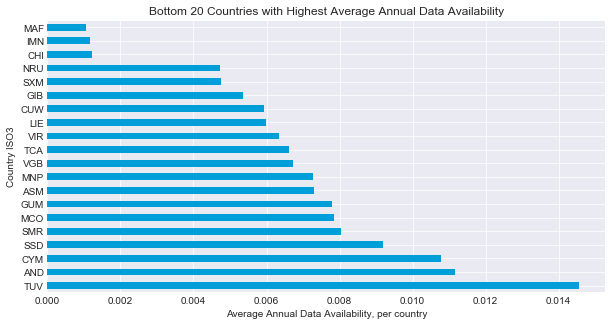

In [47]:
plt.title("Bottom 20 Countries with Highest Average Annual Data Availability")
plt.ylabel("Country ISO3")
plt.xlabel("Average Annual Data Availability, per country")
by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=False).tail(20).plot(kind='barh', figsize=(10,5))

### Follow-up analysis of Top/Bottom 20 countries

In [153]:
top20 = by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=False).head(20).index
bottom20 = by_country[list_timeframe_all].mean(axis=1).sort_values(ascending=True).head(20).index

print('top 20:',top20)
print('bottom 20:', bottom20)

top 20: Index(['USA', 'CAN', 'COL', 'BRA', 'KOR', 'ZAF', 'MEX', 'CHL', 'ARG', 'TUR',
       'IND', 'SWE', 'THA', 'GBR', 'NLD', 'PHL', 'FRA', 'NOR', 'MYS', 'ISR'],
      dtype='object', name='Country ISO3')
bottom 20: Index(['MAF', 'IMN', 'CHI', 'NRU', 'SXM', 'GIB', 'CUW', 'LIE', 'VIR', 'TCA',
       'VGB', 'MNP', 'ASM', 'GUM', 'MCO', 'SMR', 'SSD', 'CYM', 'AND', 'TUV'],
      dtype='object', name='Country ISO3')


In [154]:
top20_countries = df_tc_countries[df_tc_countries.index.isin(top20)]
bot20_countries = df_tc_countries[df_tc_countries.index.isin(bottom20)]

In [155]:
bot20_countries

adminRegion  aggregate       capitalCity  \
id                                             
ASM         EAP      False         Pago Pago   
AND        None      False  Andorra la Vella   
VGB        None      False         Road Town   
CYM        None      False       George Town   
CHI        None      False              None   
CUW        None      False        Willemstad   
GIB        None      False              None   
GUM        None      False             Agana   
IMN        None      False           Douglas   
LIE        None      False             Vaduz   
MCO        None      False            Monaco   
NRU        None      False    Yaren District   
MNP        None      False            Saipan   
SMR        None      False        San Marino   
SXM        None      False       Philipsburg   
SSD         SSA      False              Juba   
MAF        None      False           Marigot   
TCA        None      False        Grand Turk   
TUV         EAP      False          Funafuti   
VIR        None      False  Charlotte Amalie   

                                                 geo incomeLevel iso2 iso3  \
id                                                                           
ASM               {'lat': -14.2846, 'lng': -170.691}         UMC   AS  ASM   
AND                  {'lat': 42.5075, 'lng': 1.5218}         HIC   AD  AND   
VGB            {'lat': 18.431389, 'lng': -64.623056}         HIC   VG  VGB   
CYM                {'lat': 19.3022, 'lng': -81.3857}         HIC   KY  CYM   
CHI                       {'lat': None, 'lng': None}         HIC   JG  CHI   
CUW                       {'lat': None, 'lng': None}         HIC   CW  CUW   
GIB                       {'lat': None, 'lng': None}         HIC   GI  GIB   
GUM                 {'lat': 13.4443, 'lng': 144.794}         HIC   GU  GUM   
IMN                {'lat': 54.1509, 'lng': -4.47928}         HIC   IM  IMN   
LIE                 {'lat': 47.1411, 'lng': 9.52148}         HIC   LI  LIE   
MCO                 {'lat': 43.7325, 'lng': 7.41891}         HIC   MC  MCO   
NRU  {'lat': -0.5477000000000001, 'lng': 166.920867}         HIC   NR  NRU   
MNP                 {'lat': 15.1935, 'lng': 145.765}         HIC   MP  MNP   
SMR                 {'lat': 43.9322, 'lng': 12.4486}         HIC   SM  SMR   
SXM                       {'lat': None, 'lng': None}         HIC   SX  SXM   
SSD                       {'lat': 4.85, 'lng': 31.6}         LIC   SS  SSD   
MAF                       {'lat': None, 'lng': None}         HIC   MF  MAF   
TCA           {'lat': 21.4602778, 'lng': -71.141389}         HIC   TC  TCA   
TUV           {'lat': -8.6314877, 'lng': 179.089567}         UMC   TV  TUV   
VIR                {'lat': 18.3358, 'lng': -64.8963}         HIC   VI  VIR   

     landlocked lendingType                       name region  sids  
id                                                                   
ASM         NaN         LNX             American Samoa    EAS   NaN  
AND         NaN         LNX                    Andorra    ECS   NaN  
VGB         NaN         LNX     British Virgin Islands    LCN   NaN  
CYM         NaN         LNX             Cayman Islands    LCN   NaN  
CHI         NaN         LNX            Channel Islands    ECS   NaN  
CUW         NaN         LNX                    Curacao    LCN   NaN  
GIB         NaN         LNX                  Gibraltar    ECS   NaN  
GUM         NaN         LNX                       Guam    EAS   NaN  
IMN         NaN         LNX                Isle of Man    ECS   NaN  
LIE         NaN         LNX              Liechtenstein    ECS   NaN  
MCO         NaN         LNX                     Monaco    ECS   NaN  
NRU         NaN         IBD                      Nauru    EAS   NaN  
MNP         NaN         LNX   Northern Mariana Islands    EAS   NaN  
SMR         NaN         LNX                 San Marino    ECS   NaN  
SXM         NaN         LNX  Sint Maarten (Dutch part)    LCN   NaN  
SSD         1.0         IDX             

In [156]:
pd.DataFrame(top20_countries['name'].loc[top20]).reset_index()

Country ISO3            name
0           USA   United States
1           CAN          Canada
2           COL        Colombia
3           BRA          Brazil
4           KOR     Korea, Rep.
5           ZAF    South Africa
6           MEX          Mexico
7           CHL           Chile
8           ARG       Argentina
9           TUR          Turkey
10          IND           India
11          SWE          Sweden
12          THA        Thailand
13          GBR  United Kingdom
14          NLD     Netherlands
15          PHL     Philippines
16          FRA          France
17          NOR          Norway
18          MYS        Malaysia
19          ISR          Israel

In [157]:
pd.DataFrame(bot20_countries['name'].loc[bottom20]).reset_index()

Country ISO3                       name
0           MAF   St. Martin (French part)
1           IMN                Isle of Man
2           CHI            Channel Islands
3           NRU                      Nauru
4           SXM  Sint Maarten (Dutch part)
5           GIB                  Gibraltar
6           CUW                    Curacao
7           LIE              Liechtenstein
8           VIR      Virgin Islands (U.S.)
9           TCA   Turks and Caicos Islands
10          VGB     British Virgin Islands
11          MNP   Northern Mariana Islands
12          ASM             American Samoa
13          GUM                       Guam
14          MCO                     Monaco
15          SMR                 San Marino
16          SSD                South Sudan
17          CYM             Cayman Islands
18          AND                    Andorra
19          TUV                     Tuvalu

In [158]:
top20_countries["country_rank"] = "top20"
bot20_countries["country_rank"] = "bottom20"

C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\mrpso\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [159]:
topbot20_countries = pd.concat([top20_countries,bot20_countries])

In [160]:
key_country_columns = ['incomeLevel', 'lendingType', 'landlocked', 'region', 'sids']

In [161]:
df_tc_countries.head()

adminRegion  aggregate       capitalCity  \
id                                             
AFG         SAS      False             Kabul   
ALB         ECA      False            Tirane   
DZA         MNA      False           Algiers   
ASM         EAP      False         Pago Pago   
AND        None      False  Andorra la Vella   

                                    geo incomeLevel iso2 iso3  landlocked  \
id                                                                          
AFG    {'lat': 34.5228, 'lng': 69.1761}         LIC   AF  AFG         1.0   
ALB    {'lat': 41.3317, 'lng': 19.8172}         UMC   AL  ALB         0.0   
DZA    {'lat': 36.7397, 'lng': 3.05097}         UMC   DZ  DZA         0.0   
ASM  {'lat': -14.2846, 'lng': -170.691}         UMC   AS  ASM         NaN   
AND     {'lat': 42.5075, 'lng': 1.5218}         HIC   AD  AND         NaN   

    lendingType            name region  sids  
id                                            
AFG         IDX     Afghanistan    SAS   0.0  
ALB         IBD         Albania    ECS   0.0  
DZA         IBD         Algeria    MEA   0.0  
ASM         LNX  American Samoa    EAS   NaN  
AND         LNX         Andorra    ECS   NaN

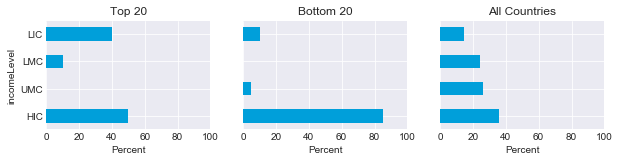

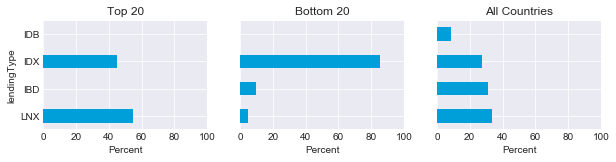

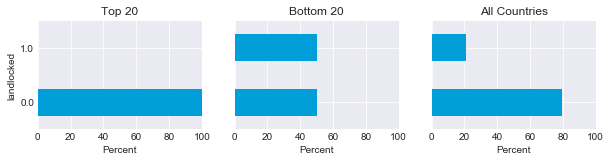

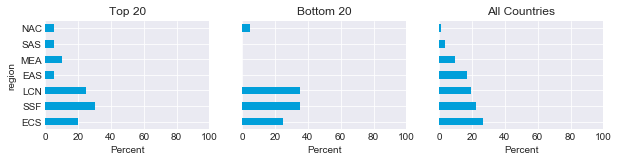

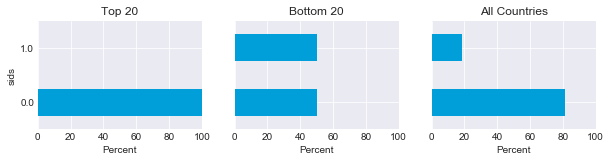

In [162]:
for col in key_country_columns:
    df_temp = topbot20_countries.groupby("country_rank")[col].value_counts(normalize=True).unstack(level=0).fillna(0)*100
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,2))
    df_temp['top20'].plot(kind="barh", ax=ax1)
    ax1.set_title('Top 20')
    ax1.set_xlim(0,100)
    ax1.set_xlabel("Percent")

    df_temp['bottom20'].plot(kind="barh", ax=ax2)
    ax2.set_title('Bottom 20')
    ax2.set_xlim(0,100)
    ax2.set_xlabel("Percent")
    
    df_all = df_tc_countries[col].value_counts(normalize=True)*100
    df_all.plot(kind="barh", ax=ax3)
    ax3.set_title('All Countries')
    ax3.set_xlim(0,100)
    ax3.set_xlabel("Percent")
    
    plt.show()

## Clustering country-level timeseries

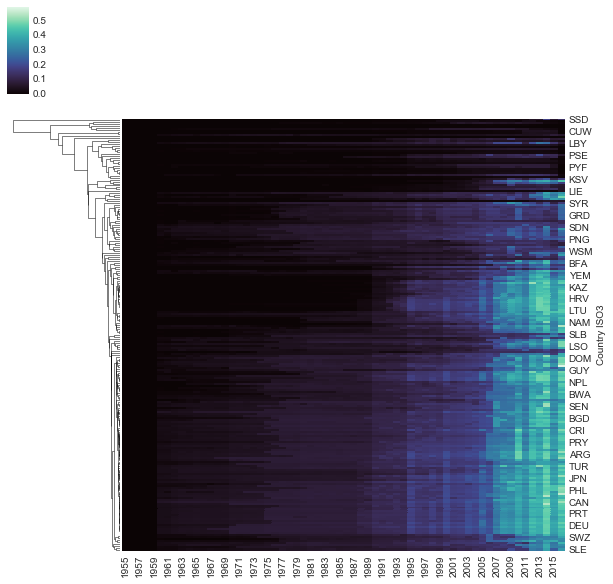

In [36]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', col_cluster=False)

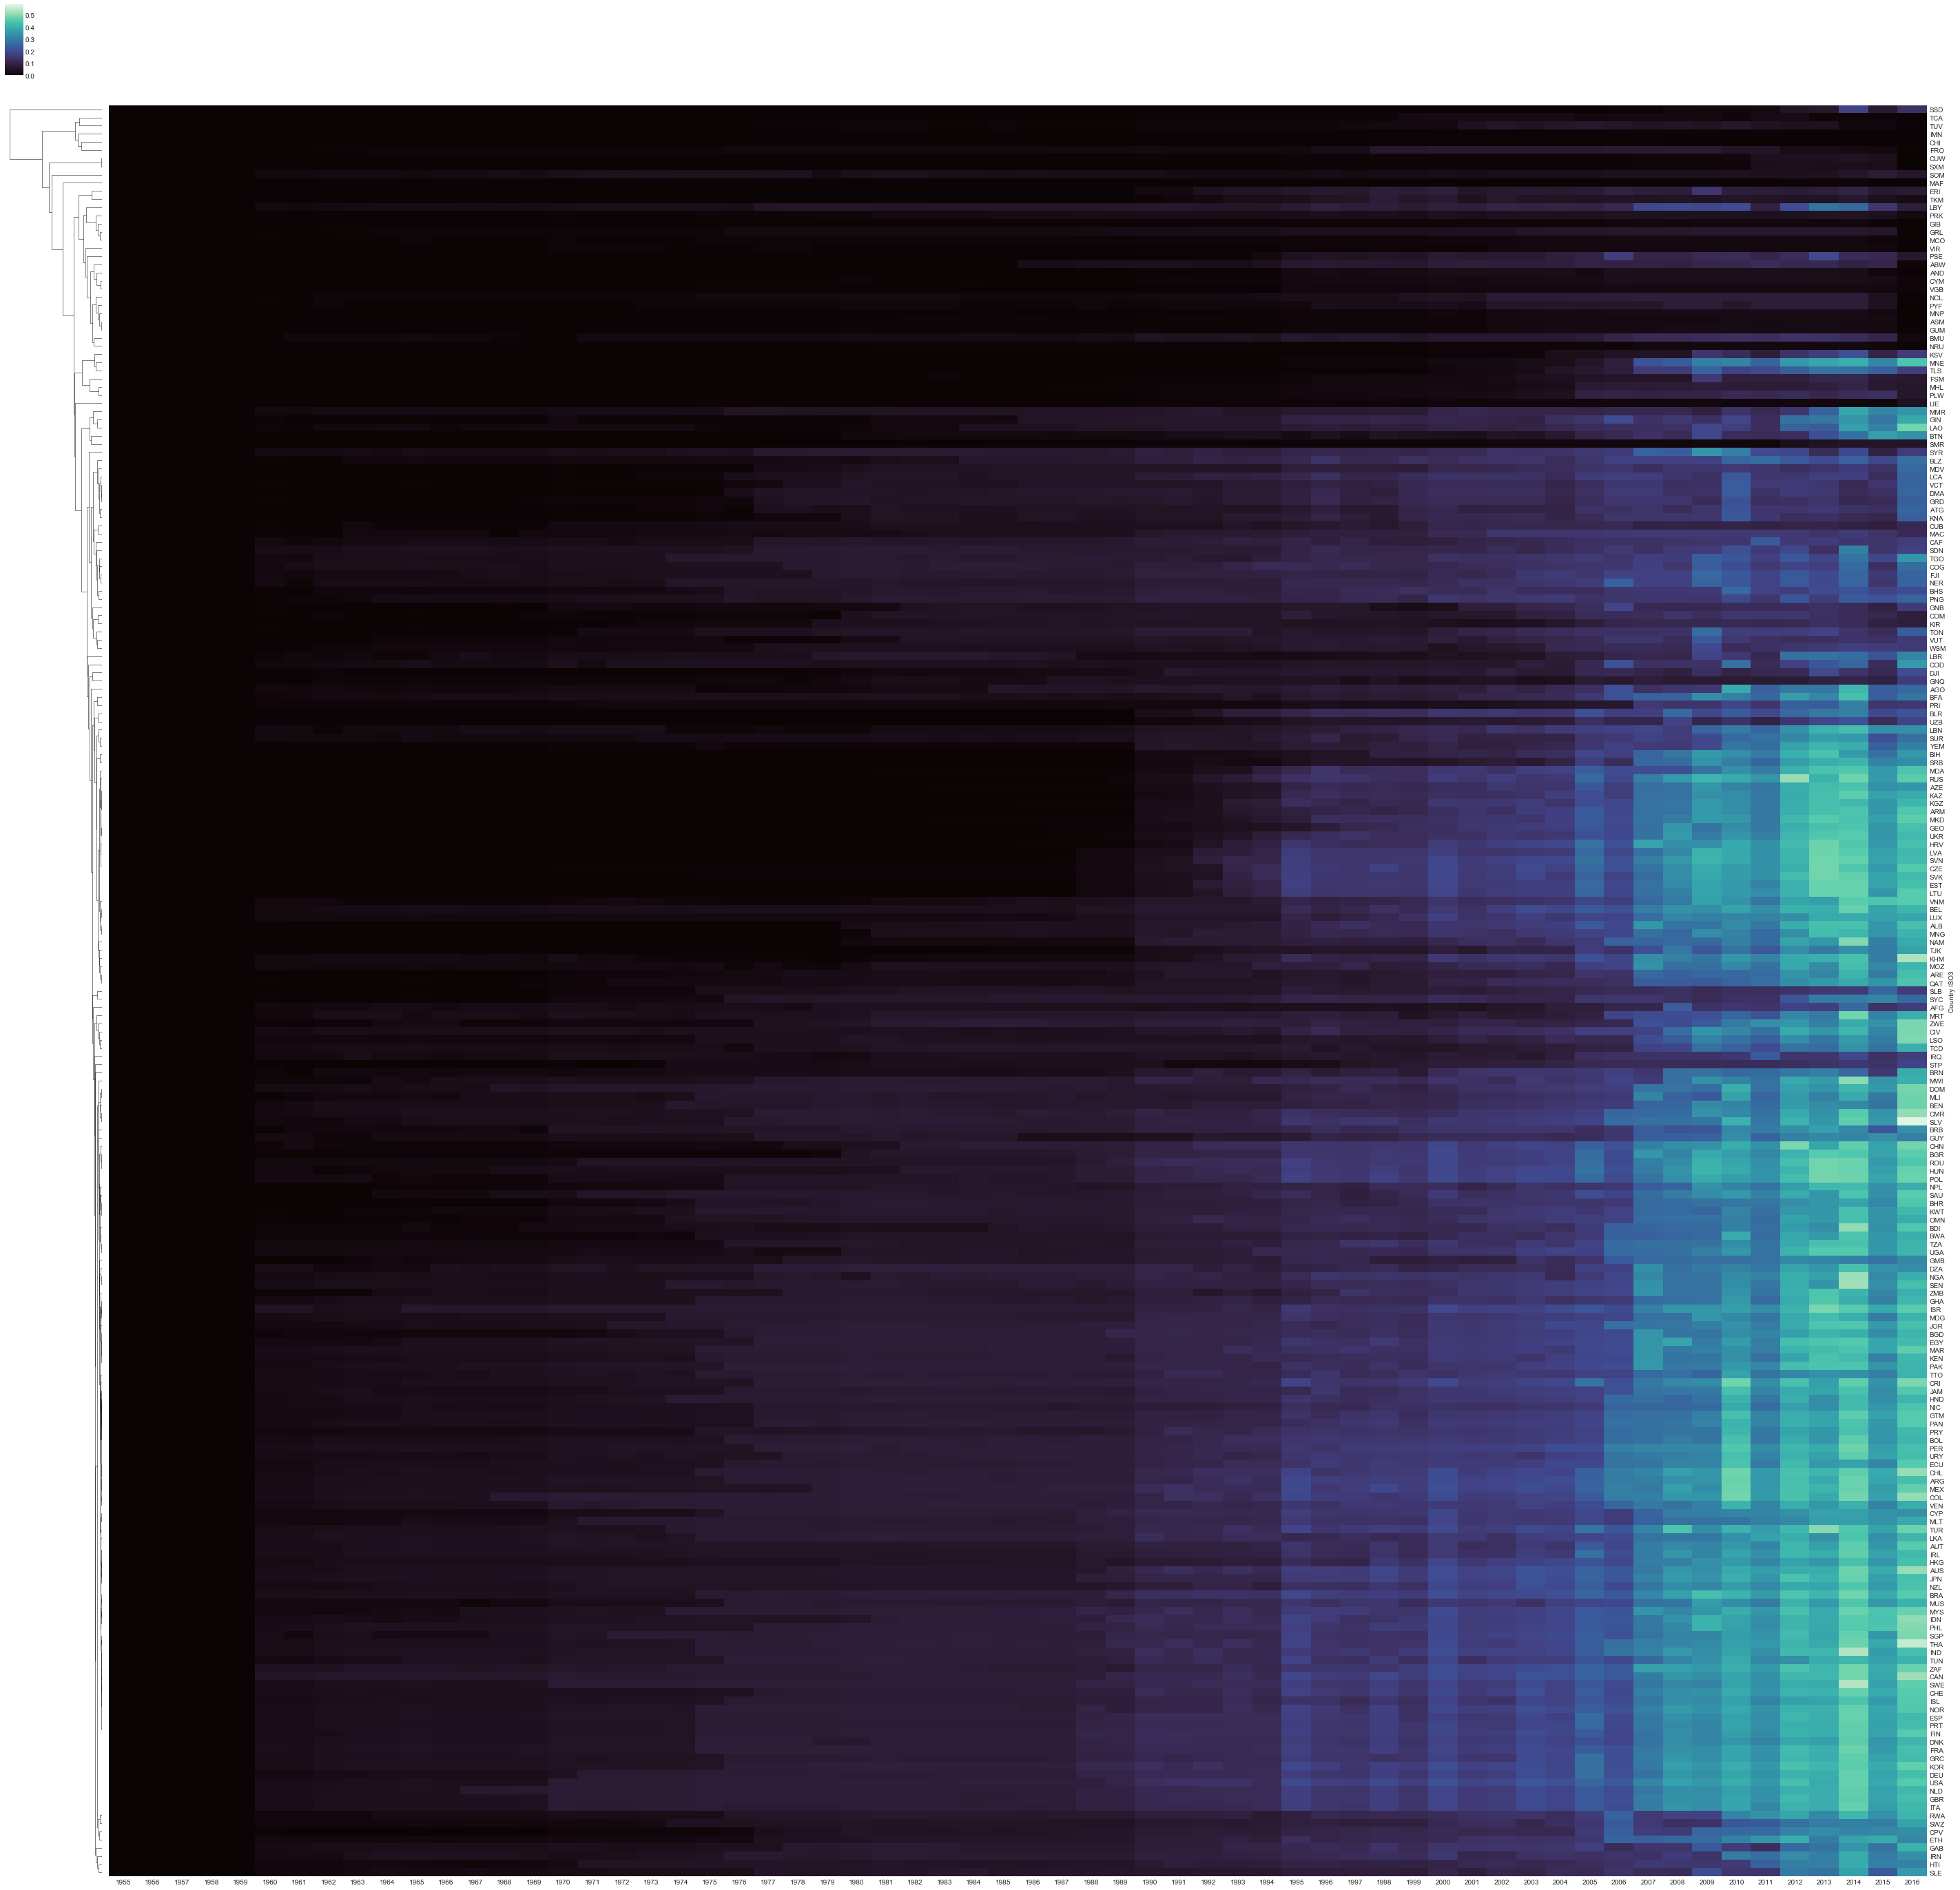

In [37]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', col_cluster=False, figsize=(50,50))

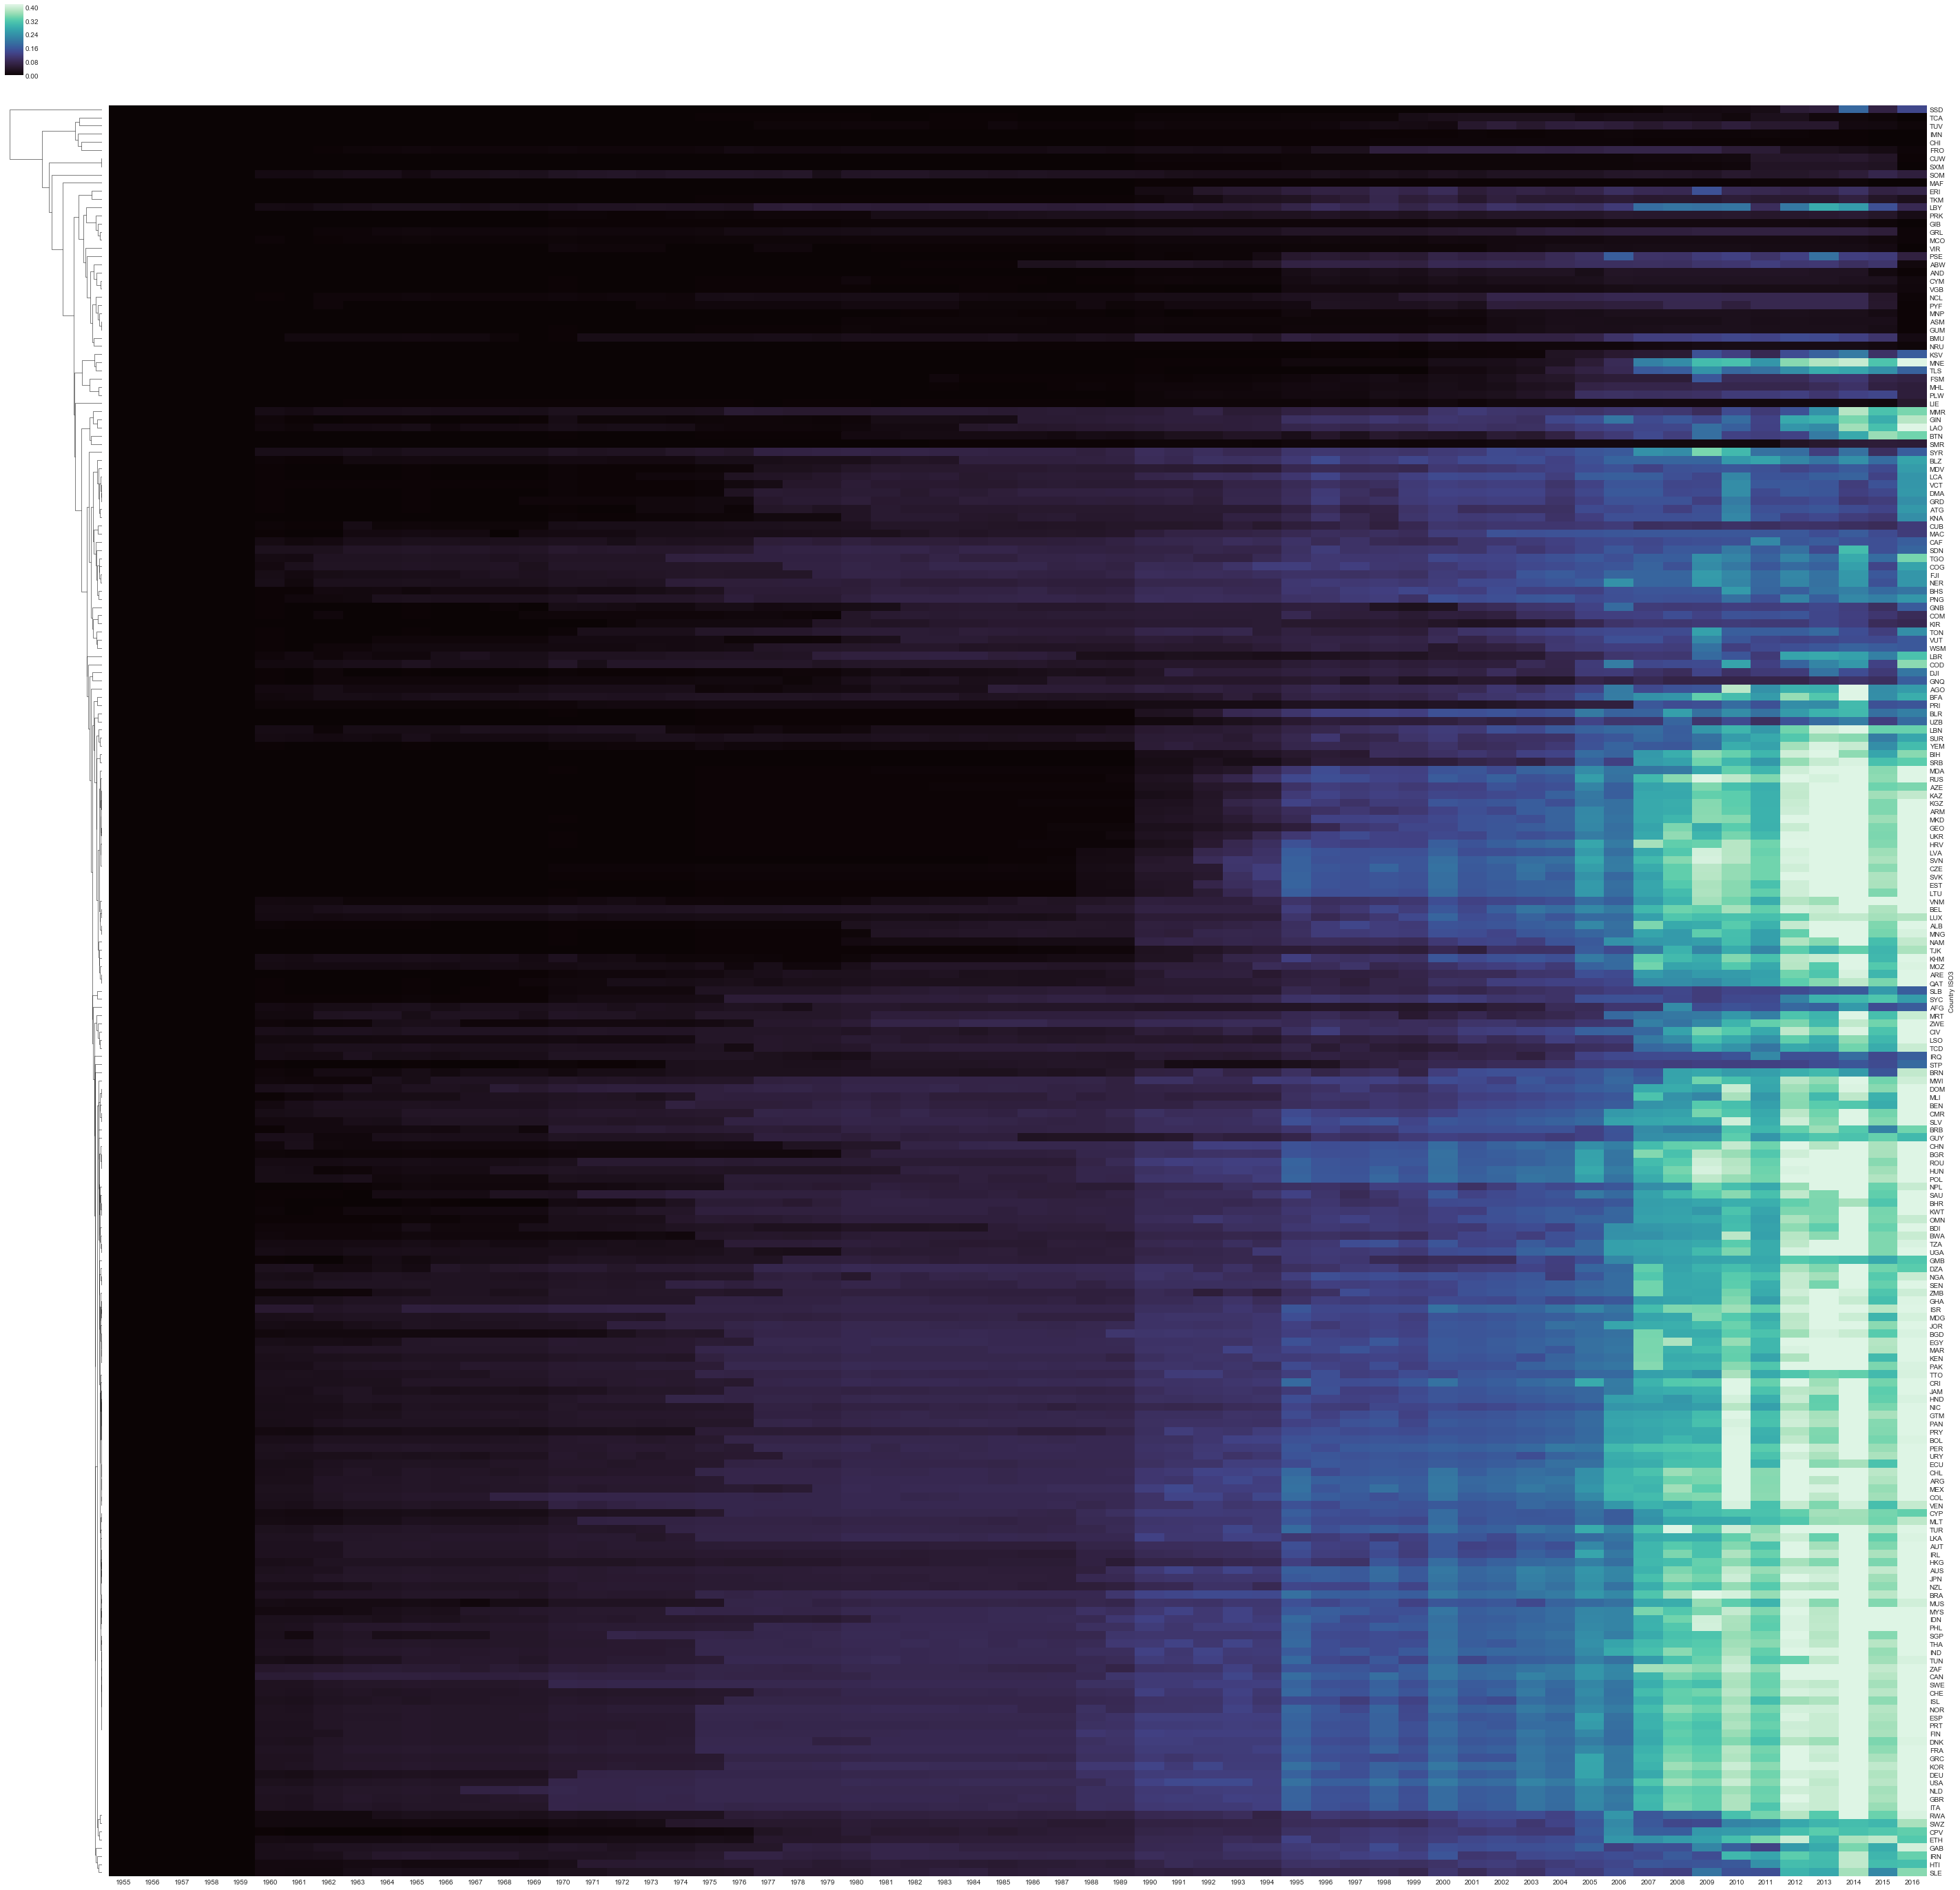

In [38]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", metric ='cosine', robust=True, col_cluster=False, figsize=(50,50)) #ignores outliers

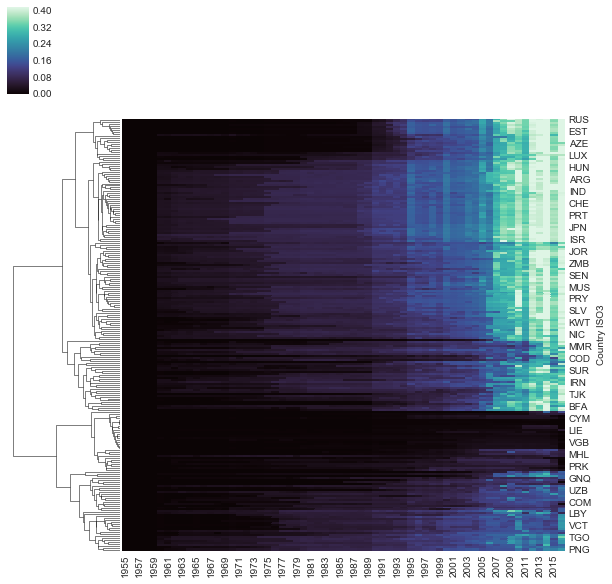

In [39]:
g = sns.clustermap(by_country[list_timeframe_all], cmap="mako", robust=True, col_cluster=False) #ignores outliers

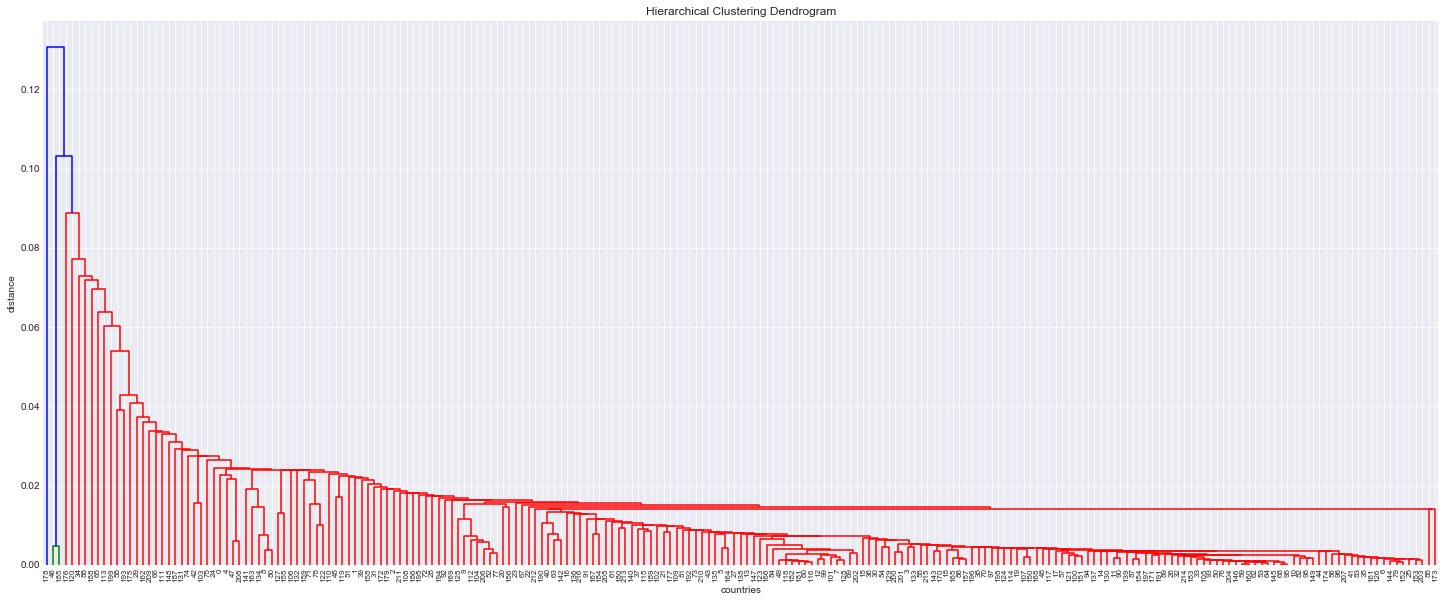

In [136]:
Z = hac.linkage(by_country[list_timeframe_all], 'single', 'cosine')

# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

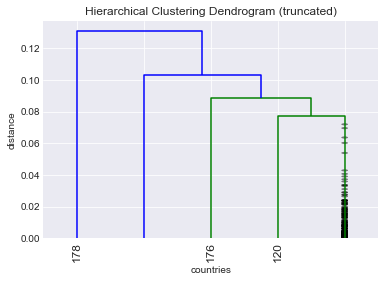

In [137]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

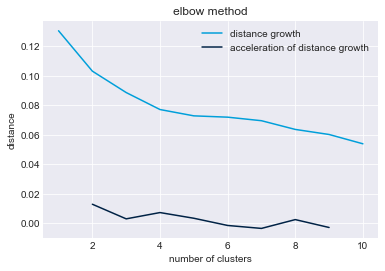

clusters: 2


In [138]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label='distance growth')

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label="acceleration of distance growth")
plt.legend()
plt.xlabel("number of clusters")
plt.ylabel("distance")
plt.title("elbow method")
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [139]:
def generate_clusters(Z, param, criterion='maxclust'):
    by_country['cluster'] = hac.fcluster(Z, param, criterion=criterion)
    by_country_melt = pd.melt(by_country.reset_index(),id_vars = ['Country ISO3','region', 'incomeLevel', 'lendingType','cluster'], 
                              value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
    plt.figure(figsize=(15,5))
    sns.tsplot(data=by_country_melt, time='Period', value='Observation', unit='Country ISO3', condition = 'cluster',
               err_style="unit_traces", err_kws = {'alpha': 0.05})
    plt.title("Cluster cutoff determined by %s = %0.2f" % (criterion, param))
    
    check_temp = pd.DataFrame(by_country['cluster'].value_counts()).reset_index()
    check_temp.columns = ['cluster', 'number_of_members']
    check_temp.set_index("cluster", inplace=True)
    check_temp = check_temp.join(pd.DataFrame(by_country.reset_index().groupby(['cluster'])['Country ISO3'].apply(lambda x: list(x))))
    check_temp.sort_index()
    return(by_country_melt, check_temp.sort_index())

### Based on Elbow Method

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                       Country ISO3
cluster                                                                      
1                      216  [ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ...
2                        1                                              [SSD]

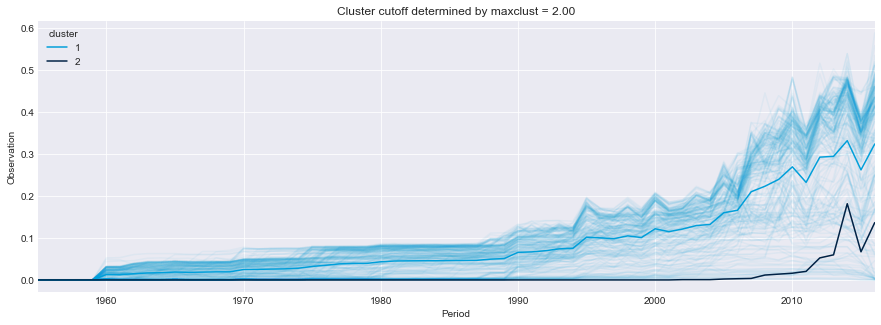

In [140]:
by_country_melt, check_temp = generate_clusters(Z, 2, criterion='maxclust')
check_temp

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                       Country ISO3
cluster                                                                      
1                        2                                         [CUW, SXM]
2                      214  [ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ...
3                        1                                              [SSD]

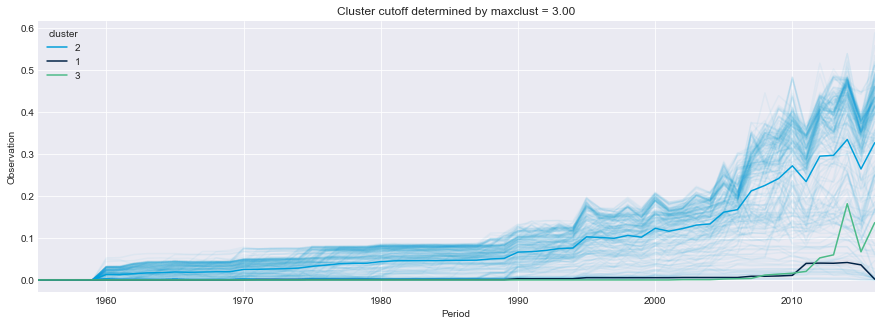

In [91]:
by_country_melt, check_temp = generate_clusters(Z, 3, criterion='maxclust')
check_temp

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                       Country ISO3
cluster                                                                      
1                        2                                         [CUW, SXM]
2                      213  [ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ...
3                        1                                              [SOM]
4                        1                                              [SSD]

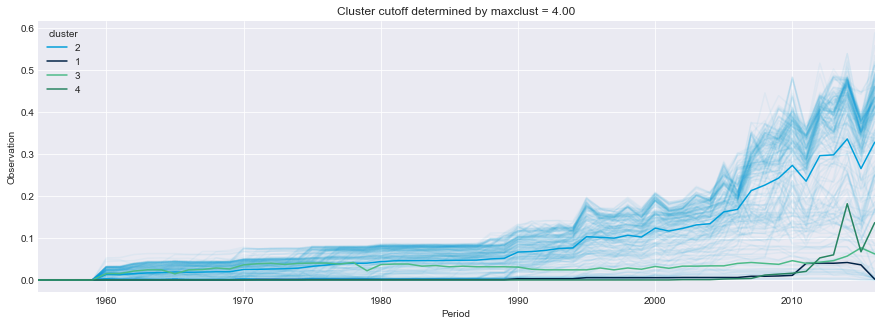

In [92]:
by_country_melt, check_temp = generate_clusters(Z, 4, criterion='maxclust')
check_temp

### Based on Max Distance

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                       Country ISO3
cluster                                                                      
1                        2                                         [CUW, SXM]
2                        2                                         [ERI, TKM]
3                      203  [ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ...
4                        1                                              [SMR]
5                        1                                              [TUV]
6                        1                                              [LIE]
7                        1                                              [FRO]
8                        1                                              [TCA]
9                        1                                              [IMN]
10                       1                                              [CHI]
11                       1                                              [MAF]
12                       1                                              [SOM]
13                       1                                              [SSD]

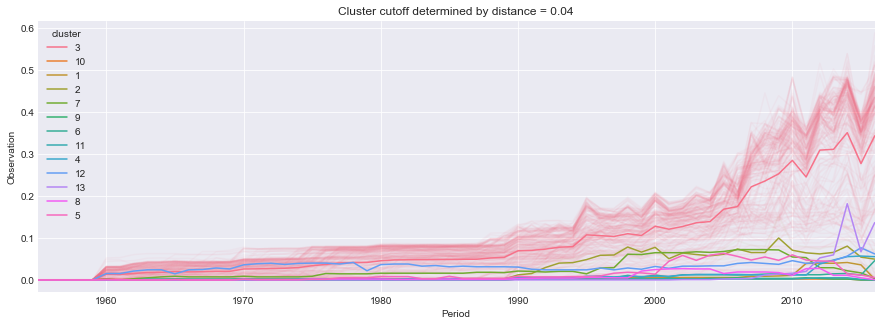

In [115]:
by_country_melt, check_temp = generate_clusters(Z, 0.04, criterion='distance')
check_temp

## Choropleth Map

In [129]:
map_by_country = by_country[list_timeframe_all].mean(axis=1)
map_by_country = pd.concat([map_by_country, df_tc_countries['name']], axis=1)
map_by_country = map_by_country.reset_index()
map_by_country.columns = ['iso3', 'ave_data_avail', 'name']

In [130]:
map_by_country.head()

iso3  ave_data_avail         name
0  ABW        0.036138        Aruba
1  AFG        0.056909  Afghanistan
2  AGO        0.077464       Angola
3  ALB        0.099192      Albania
4  AND        0.011152      Andorra

In [131]:
init_notebook_mode(connected=True)

In [133]:
data = [ dict(
        type = 'choropleth',
        locations = map_by_country['iso3'],
        z = map_by_country['ave_data_avail'],
        text = map_by_country['name'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.25,"rgb(70, 100, 245)"],[0.5,"rgb(106, 137, 247)"],[1.0,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            ticksuffix = '%',
            title = 'Ave. Annual<br>Data Availability<br>Percent(%)'),
      ) ]

layout = dict(
    title = 'Average Annual Data Availability, by Country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

# Topic-level Data Analysis

In [141]:
df_merged2.head()

1955  1956  1957  1958  1959  1960  1961  1962  1963  1964  \
6422   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6423   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6424   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6425   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6426   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 ...               2012  2013  2014  2015  2016  Country ISO3  \
6422             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6423             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6424             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6425             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6426             ...                0.0   0.0   1.0   0.0   0.0           AFG   

      dataset_id  indicatorId   topiclvl1                    topiclvl2  
6422          49        228.0  Investment         Entry and Investment  
6423          49        276.0  Innovation                Firm Dynamics  
6424          49        277.0  Innovation                Firm Dynamics  
6425          49        280.0  Investment  Risk and Policy Uncertainty  
6426          49        279.0  Investment  Risk and Policy Uncertainty  

[5 rows x 67 columns]

In [143]:
total_indicators_per_topic = df_merged2.groupby(['topiclvl1'])['indicatorId'].apply(lambda x: len(x.unique()))
total_indicators_per_topic

topiclvl1
Innovation    213
Investment    521
Sectors        90
Trade         550
Name: indicatorId, dtype: int64

In [144]:
by_topic = (df_merged2.groupby(['topiclvl1', 'Country ISO3'])[list_timeframe_all].sum().unstack(level=0).fillna(0).mean().unstack(level=-1)/total_indicators_per_topic).T

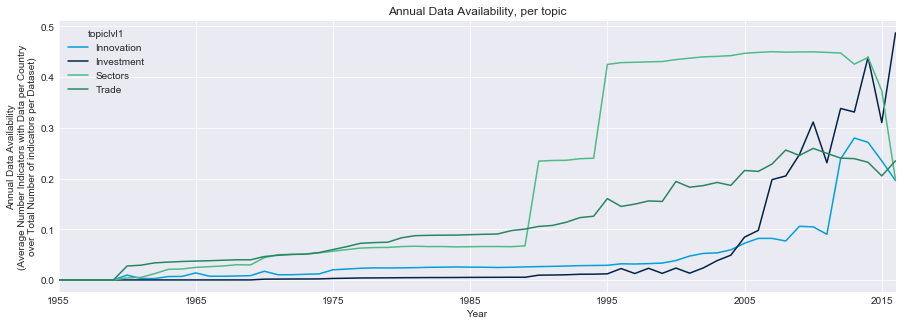

In [147]:
by_topic[list_timeframe_all].T.plot(figsize=(15,5))
plt.title("Annual Data Availability, per topic")
plt.ylabel("Annual Data Availability\n(Average Number Indicators with Data per Country\nover Total Number of indicators per Dataset)")
plt.xlabel("Year")

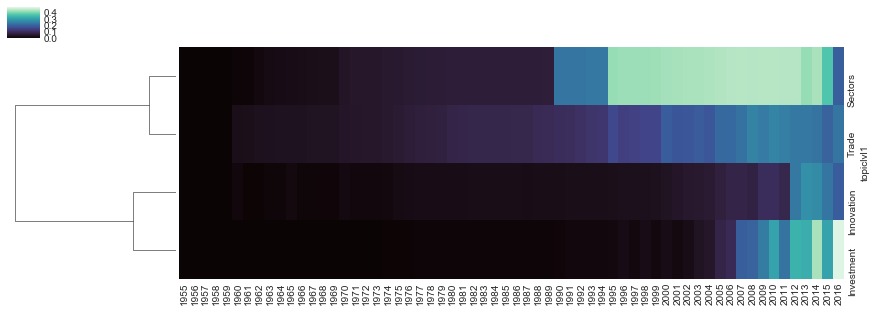

In [149]:
g = sns.clustermap(by_topic[list_timeframe_all], cmap="mako", col_cluster=False, metric ='cosine', figsize=(15,5))

# Subtopic-level Data Analysis

In [155]:
df_merged2.head()

1955  1956  1957  1958  1959  1960  1961  1962  1963  1964  \
6422   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6423   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6424   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6425   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6426   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                 ...               2012  2013  2014  2015  2016  Country ISO3  \
6422             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6423             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6424             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6425             ...                0.0   0.0   1.0   0.0   0.0           AFG   
6426             ...                0.0   0.0   1.0   0.0   0.0           AFG   

      dataset_id  indicatorId   topiclvl1                    topiclvl2  
6422          49        228.0  Investment         Entry and Investment  
6423          49        276.0  Innovation                Firm Dynamics  
6424          49        277.0  Innovation                Firm Dynamics  
6425          49        280.0  Investment  Risk and Policy Uncertainty  
6426          49        279.0  Investment  Risk and Policy Uncertainty  

[5 rows x 67 columns]

In [156]:
df_merged2['topiclvl2'].value_counts()

Reform Progress                       38675
Trade Outcomes                        37801
Trade Facilitation                    18211
Entrepreneurship                      13833
Entry and Investment                  12312
Risk and Policy Uncertainty            9595
Cost of Operations                     8751
Trade Barriers                         8528
Tourism                                8134
Perceived Constraints                  6035
E-trade                                4098
Manufacturing                          3795
Innovation Inputs                      3081
Competition and Competition Policy     2486
Innovation Outputs                     2431
Climate Competitiveness                1735
Firm Dynamics                          1305
Connectivity                           1208
Name: topiclvl2, dtype: int64

In [158]:
len(df_merged2['topiclvl2'].unique())

18

In [160]:
df_merged2[['topiclvl1','topiclvl2']].drop_duplicates().shape

(18, 2)

In [161]:
total_indicators_per_subtopic = df_merged2.groupby(['topiclvl2'])['indicatorId'].apply(lambda x: len(x.unique()))
total_indicators_per_subtopic

topiclvl2
Climate Competitiveness                11
Competition and Competition Policy     39
Connectivity                            7
Cost of Operations                     82
E-trade                                27
Entrepreneurship                      106
Entry and Investment                   85
Firm Dynamics                          13
Innovation Inputs                      75
Innovation Outputs                     19
Manufacturing                          27
Perceived Constraints                  43
Reform Progress                       253
Risk and Policy Uncertainty            58
Tourism                                52
Trade Barriers                         73
Trade Facilitation                    168
Trade Outcomes                        236
Name: indicatorId, dtype: int64

In [162]:
by_subtopic = (df_merged2.groupby(['topiclvl2', 'Country ISO3'])[list_timeframe_all].sum().unstack(level=0).fillna(0).mean().unstack(level=-1)/total_indicators_per_subtopic).T

In [215]:
topic_hier = df_merged2[['topiclvl1','topiclvl2']].drop_duplicates().set_index('topiclvl2')

In [218]:
by_subtopic = by_subtopic.join(topic_hier)

In [219]:
by_subtopic.head()

1955  1956  1957  1958  1959      1960  \
topiclvl2                                                                    
Climate Competitiveness              0.0   0.0   0.0   0.0   0.0  0.021366   
Competition and Competition Policy   0.0   0.0   0.0   0.0   0.0  0.000000   
Connectivity                         0.0   0.0   0.0   0.0   0.0  0.000000   
Cost of Operations                   0.0   0.0   0.0   0.0   0.0  0.000000   
E-trade                              0.0   0.0   0.0   0.0   0.0  0.000000   

                                        1961      1962      1963      1964  \
topiclvl2                                                                    
Climate Competitiveness             0.028488  0.028907  0.029326  0.030582   
Competition and Competition Policy  0.000000  0.000000  0.000000  0.000000   
Connectivity                        0.000000  0.000000  0.000000  0.000000   
Cost of Operations                  0.000000  0.000000  0.000000  0.000000   
E-trade                             0.000000  0.000000  0.000000  0.000000   

                                       ...          2009      2010      2011  \
topiclvl2                              ...                                     
Climate Competitiveness                ...      0.496439  0.494763  0.498115   
Competition and Competition Policy     ...      0.054709  0.101382  0.057308   
Connectivity                           ...      0.429230  0.536537  0.397630   
Cost of Operations                     ...      0.149151  0.137406  0.113128   
E-trade                                ...      0.099676  0.201570  0.129544   

                                        2012      2013      2014      2015  \
topiclvl2                                                                    
Climate Competitiveness             0.496020  0.346041  0.547549  0.134059   
Competition and Competition Policy  0.129623  0.229588  0.120288  0.049628   
Connectivity                        0.456221  0.326531  0.369980  0.194207   
Cost of Operations                  0.112116  0.162808  0.234686  0.197819   
E-trade                             0.232463  0.152586  0.339990  0.238266   

                                        2016  cluster   topiclvl1  
topiclvl2                                                          
Climate Competitiveness             0.106410        6     Sectors  
Competition and Competition Policy  0.094056        8       Trade  
Connectivity                        0.309414        2       Trade  
Cost of Operations                  0.201304        3  Investment  
E-trade                             0.369688        1       Trade  

[5 rows x 64 columns]

[(0.89411764705882346, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.49411764705882361, 0.72156862745098038),
 (0.30196078431372558, 0.68627450980392157, 0.29019607843137263),
 (0.59607843137254923, 0.30588235294117649, 0.63921568627450975),
 (1.0, 0.49803921568627452, 0.0),
 (0.99999999999999978, 1.0, 0.19999999999999996),
 (0.65098039215686287, 0.33725490196078434, 0.1568627450980391),
 (0.96862745098039216, 0.50588235294117656, 0.74901960784313737),
 (0.59999999999999998, 0.59999999999999998, 0.59999999999999998)]

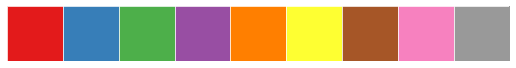

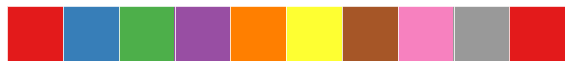

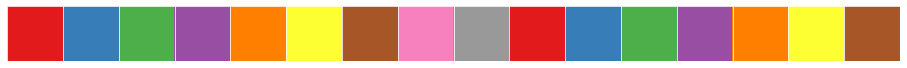

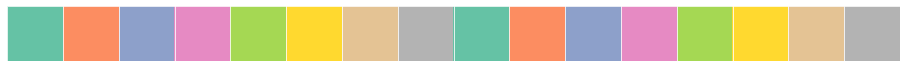

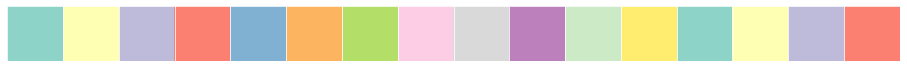

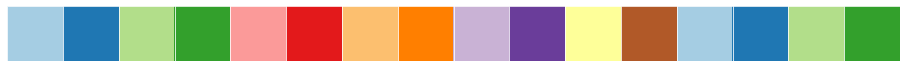

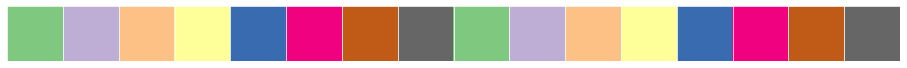

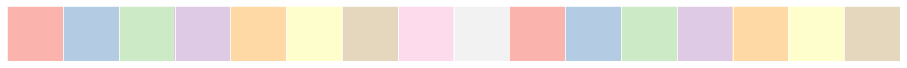

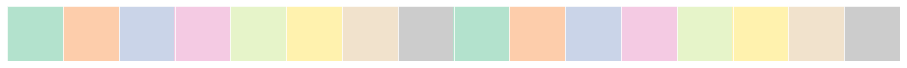

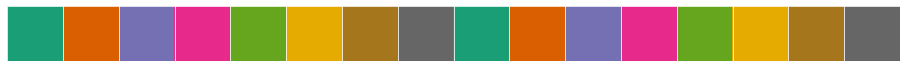

In [169]:
sns.choose_colorbrewer_palette(data_type='qualitative')

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



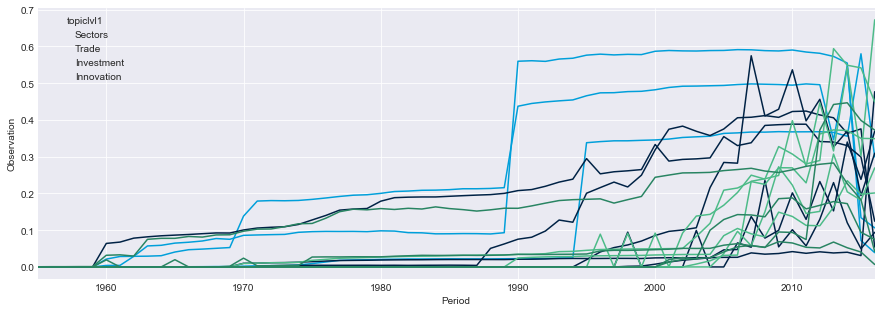

In [225]:
sns.set_palette(wbg_cat_pal)

by_subtopic_melt = pd.melt(by_subtopic.reset_index(),id_vars = ['topiclvl2', 'topiclvl1'], 
                          value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
plt.figure(figsize=(15,5))
sns.tsplot(data=by_subtopic_melt, time='Period', value='Observation', unit='topiclvl2', condition = 'topiclvl1',
           err_style="unit_traces", lw=0, err_kws = {'alpha': 1.0})

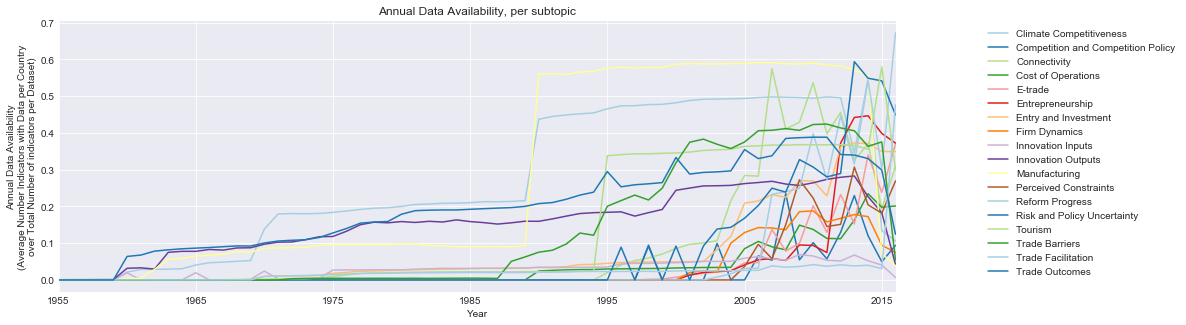

In [171]:
sns.set_palette(sns.color_palette("Paired", 16))
by_subtopic[list_timeframe_all].T.plot(figsize=(15,5))
plt.title("Annual Data Availability, per subtopic")
plt.ylabel("Annual Data Availability\n(Average Number Indicators with Data per Country\nover Total Number of indicators per Dataset)")
plt.xlabel("Year")
plt.legend(loc='best', bbox_to_anchor=(1.1,1))

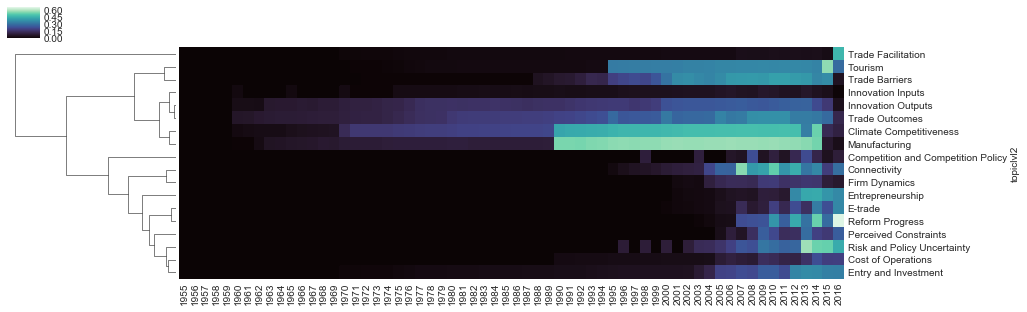

In [164]:
g = sns.clustermap(by_subtopic[list_timeframe_all], cmap="mako", col_cluster=False, metric ='cosine', figsize=(15,5))

## Subtopic-level Clusters

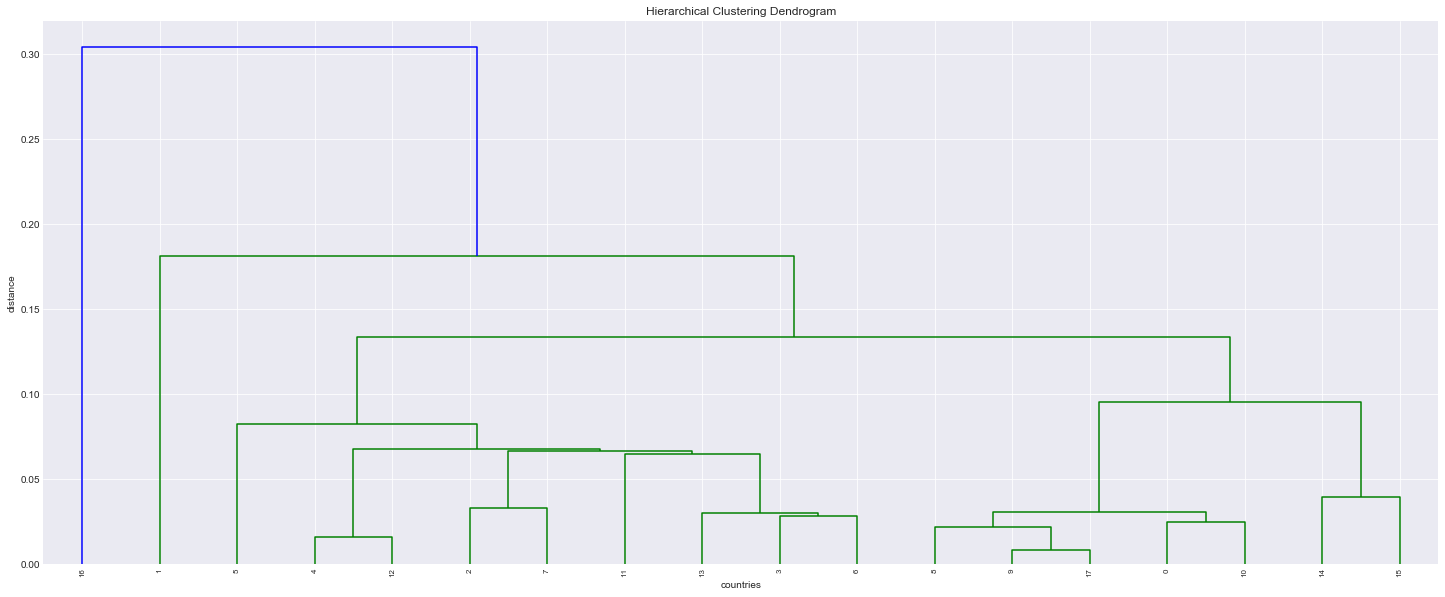

In [172]:
Z = hac.linkage(by_subtopic[list_timeframe_all], 'single', 'cosine')

# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('countries')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

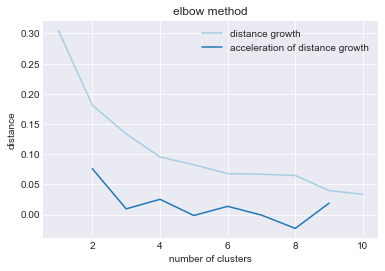

clusters: 2


In [173]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label='distance growth')

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label="acceleration of distance growth")
plt.legend()
plt.xlabel("number of clusters")
plt.ylabel("distance")
plt.title("elbow method")
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [188]:
def generate_clusters_subtopic(Z, param, criterion='maxclust'):
    by_subtopic['cluster'] = hac.fcluster(Z, param, criterion=criterion)
    by_subtopic_melt = pd.melt(by_subtopic.reset_index(),id_vars = ['topiclvl2', 'cluster'], 
                              value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
    plt.figure(figsize=(15,5))
    sns.tsplot(data=by_subtopic_melt, time='Period', value='Observation', unit='topiclvl2', condition = 'cluster',
               err_style="unit_traces", err_kws = {'alpha': 0.25})
    plt.title("Cluster cutoff determined by %s = %0.2f" % (criterion, param))
    
    check_temp = pd.DataFrame(by_subtopic['cluster'].value_counts()).reset_index()
    check_temp.columns = ['cluster', 'number_of_members']
    check_temp.set_index("cluster", inplace=True)
    check_temp = check_temp.join(pd.DataFrame(by_subtopic.reset_index().groupby(['cluster'])['topiclvl2'].apply(lambda x: list(x))))
    return(by_subtopic_melt, check_temp.sort_index())

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                        8  [Connectivity, Cost of Operations, E-trade, En...
2                        1                                 [Entrepreneurship]
3                        5  [Climate Competitiveness, Innovation Inputs, I...
4                        2                          [Tourism, Trade Barriers]
5                        1               [Competition and Competition Policy]
6                        1                               [Trade Facilitation]

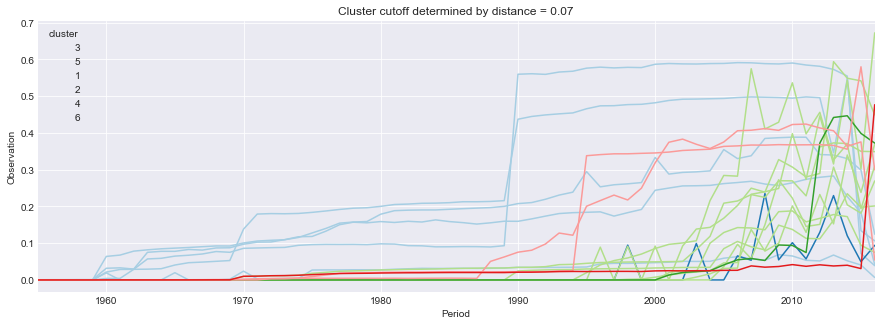

In [197]:
param = 0.07
criterion='distance'

by_subtopic['cluster'] = hac.fcluster(Z, param, criterion=criterion)
by_subtopic_melt = pd.melt(by_subtopic.reset_index(),id_vars = ['topiclvl2', 'cluster'], 
                          value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
plt.figure(figsize=(15,5))
sns.tsplot(data=by_subtopic_melt, time='Period', value='Observation', unit='topiclvl2', condition = 'cluster',
           err_style="unit_traces", lw=0, err_kws = {'alpha': 1.0})
plt.title("Cluster cutoff determined by %s = %0.2f" % (criterion, param))

check_temp = pd.DataFrame(by_subtopic['cluster'].value_counts()).reset_index()
check_temp.columns = ['cluster', 'number_of_members']
check_temp.set_index("cluster", inplace=True)
check_temp = check_temp.join(pd.DataFrame(by_subtopic.reset_index().groupby(['cluster'])['topiclvl2'].apply(lambda x: list(x))))
check_temp.sort_index()

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                        2                         [E-trade, Reform Progress]
2                        2                      [Connectivity, Firm Dynamics]
3                        3  [Cost of Operations, Entry and Investment, Ris...
4                        1                            [Perceived Constraints]
5                        1                                 [Entrepreneurship]
6                        5  [Climate Competitiveness, Innovation Inputs, I...
7                        2                          [Tourism, Trade Barriers]
8                        1               [Competition and Competition Policy]
9                        1                               [Trade Facilitation]

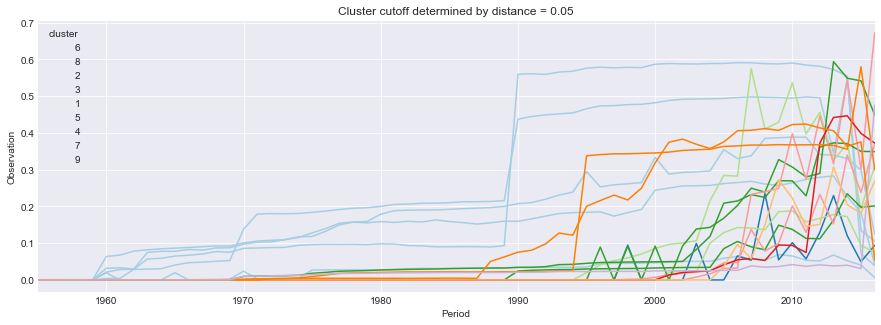

In [221]:
param = 0.05
criterion='distance'

by_subtopic['cluster'] = hac.fcluster(Z, param, criterion=criterion)
by_subtopic_melt = pd.melt(by_subtopic.reset_index(),id_vars = ['topiclvl2', 'cluster'], 
                          value_vars = list_timeframe_all, var_name="Period", value_name='Observation')
plt.figure(figsize=(15,5))
sns.tsplot(data=by_subtopic_melt, time='Period', value='Observation', unit='topiclvl2', condition = 'cluster',
           err_style="unit_traces", lw=0, err_kws = {'alpha': 1.0})
plt.title("Cluster cutoff determined by %s = %0.2f" % (criterion, param))

check_temp = pd.DataFrame(by_subtopic['cluster'].value_counts()).reset_index()
check_temp.columns = ['cluster', 'number_of_members']
check_temp.set_index("cluster", inplace=True)
check_temp = check_temp.join(pd.DataFrame(by_subtopic.reset_index().groupby(['cluster'])['topiclvl2'].apply(lambda x: list(x))))
check_temp.sort_index()

In [208]:
check_temp.loc[6]['topiclvl2']

['Climate Competitiveness',
 'Innovation Inputs',
 'Innovation Outputs',
 'Manufacturing',
 'Trade Outcomes']

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                        8  [Connectivity, Cost of Operations, E-trade, En...
2                        1                                 [Entrepreneurship]
3                        5  [Climate Competitiveness, Innovation Inputs, I...
4                        2                          [Tourism, Trade Barriers]
5                        1               [Competition and Competition Policy]
6                        1                               [Trade Facilitation]

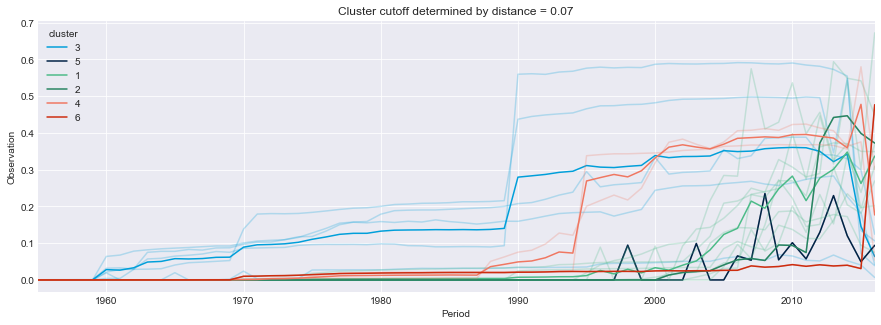

In [266]:
by_subtopic_melt, check_temp = generate_clusters_subtopic(Z, param=0.07, criterion='distance')
check_temp

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                        2                         [E-trade, Reform Progress]
2                        2                      [Connectivity, Firm Dynamics]
3                        3  [Cost of Operations, Entry and Investment, Ris...
4                        1                            [Perceived Constraints]
5                        1                                 [Entrepreneurship]
6                        5  [Climate Competitiveness, Innovation Inputs, I...
7                        2                          [Tourism, Trade Barriers]
8                        1               [Competition and Competition Policy]
9                        1                               [Trade Facilitation]

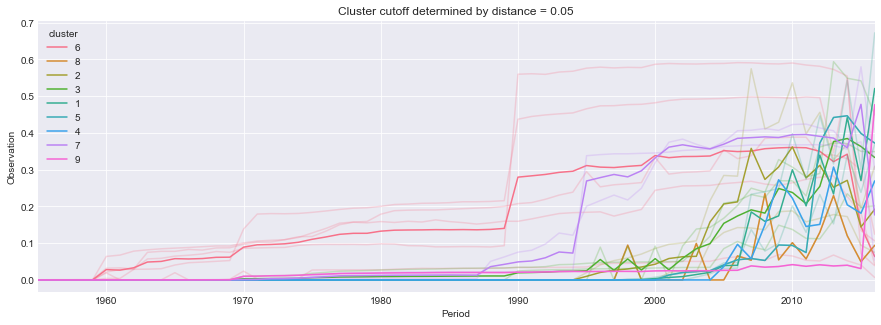

In [269]:
by_subtopic_melt, check_temp = generate_clusters_subtopic(Z, param=0.05, criterion='distance')
check_temp

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                       17  [Climate Competitiveness, Competition and Comp...
2                        1                               [Trade Facilitation]

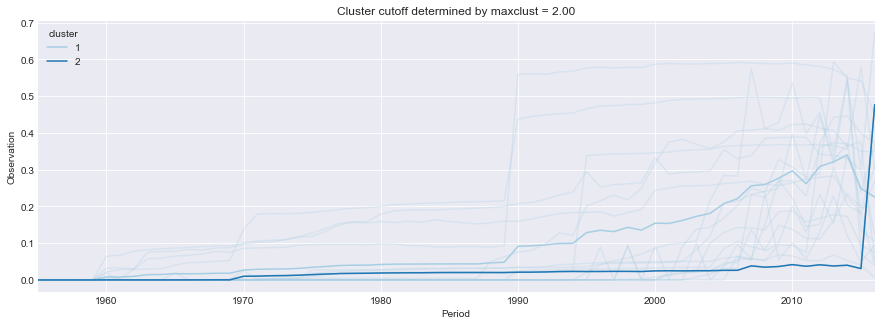

In [190]:
by_subtopic_melt, check_temp = generate_clusters_subtopic(Z, param=2)
check_temp

C:\Users\mrpso\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



number_of_members                                          topiclvl2
cluster                                                                      
1                        9  [Connectivity, Cost of Operations, E-trade, En...
2                        7  [Climate Competitiveness, Innovation Inputs, I...
3                        1               [Competition and Competition Policy]
4                        1                               [Trade Facilitation]

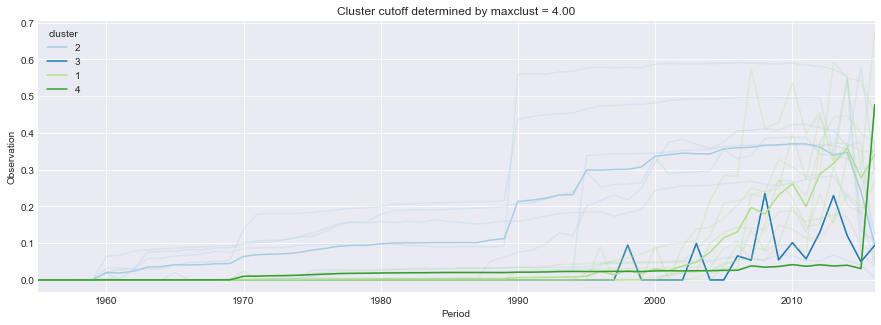

In [191]:
by_subtopic_melt, check_temp = generate_clusters_subtopic(Z, param=4)
check_temp

## Looking at Clusters for MaxDist = 0.05

In [270]:
cluster_list = sorted(list(by_subtopic['cluster'].unique()))

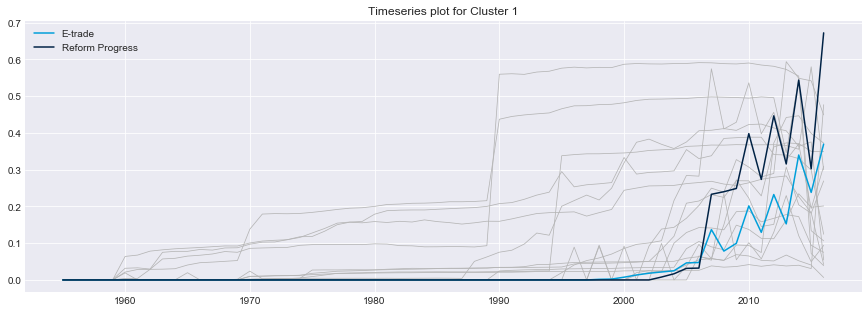

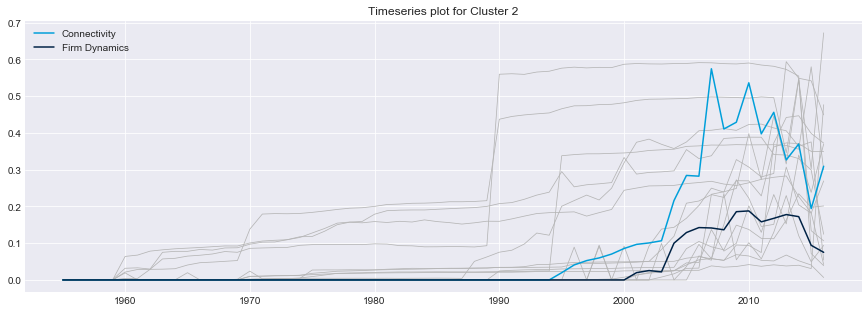

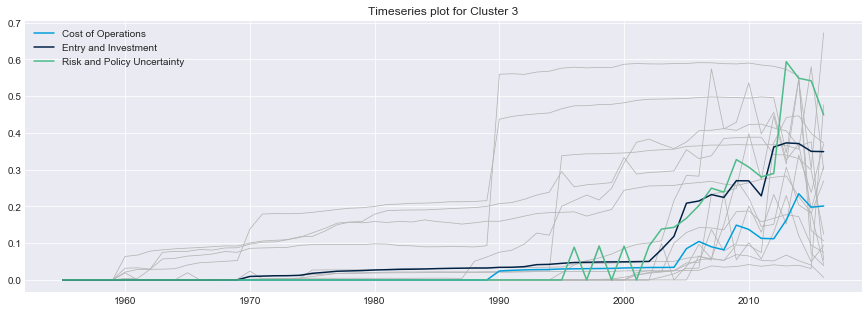

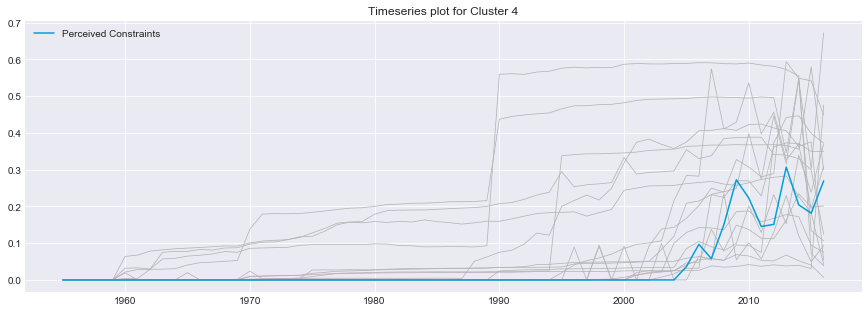

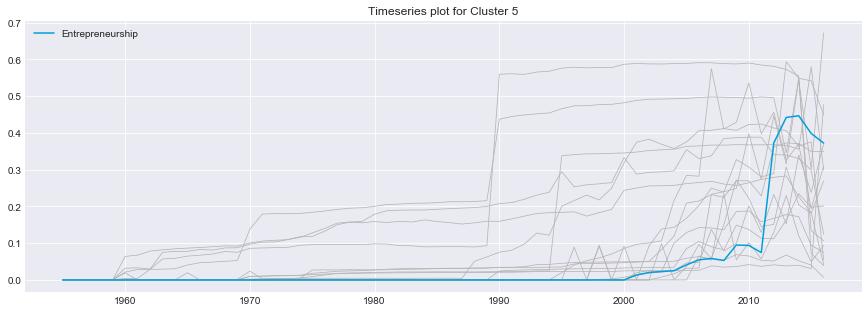

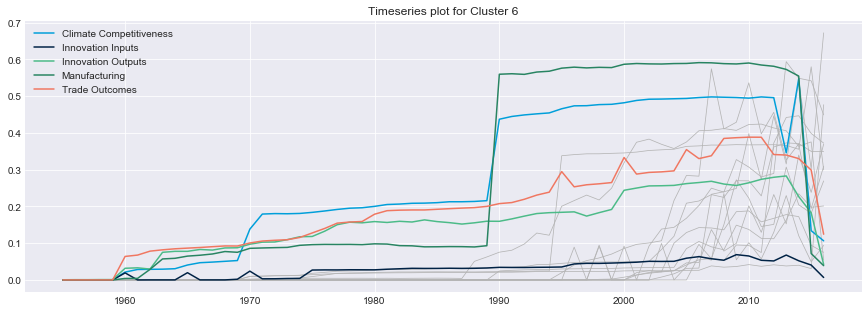

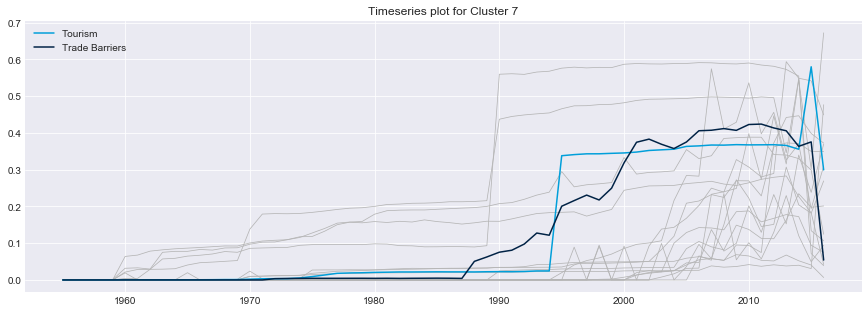

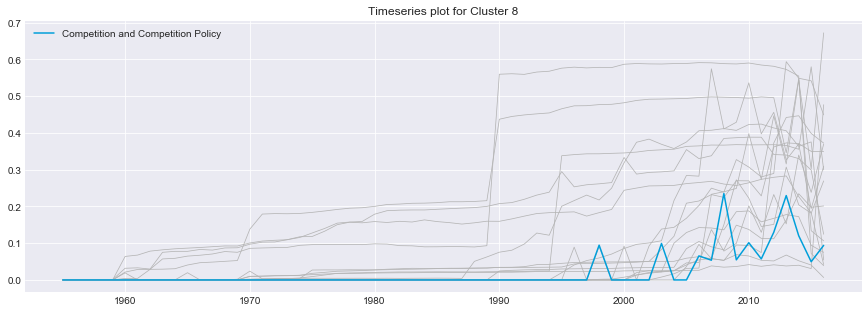

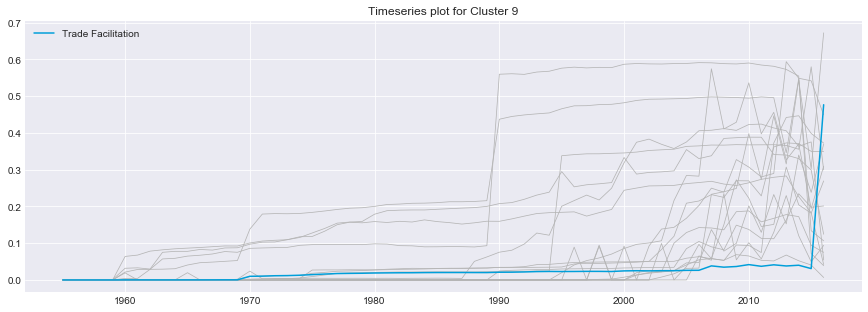

In [271]:
for cluster in cluster_list:
    plt.figure(figsize=(15,5))
    temp = by_subtopic[by_subtopic['cluster'] == cluster]
    plt.plot(by_subtopic[by_subtopic['cluster'] != cluster][list_timeframe_all].T, color='#b4b4b4', lw=0.75)
    for topic in temp[list_timeframe_all].T.columns:
        plt.plot(temp[list_timeframe_all].T[topic], label=topic)
    plt.legend()
    plt.title("Timeseries plot for Cluster %d" % cluster)
    plt.show()

# Topic- and Country-level Data Analysis

In [150]:
topic_list = df_merged2['topiclvl1'].unique()

In [151]:
len(topic_list)

4

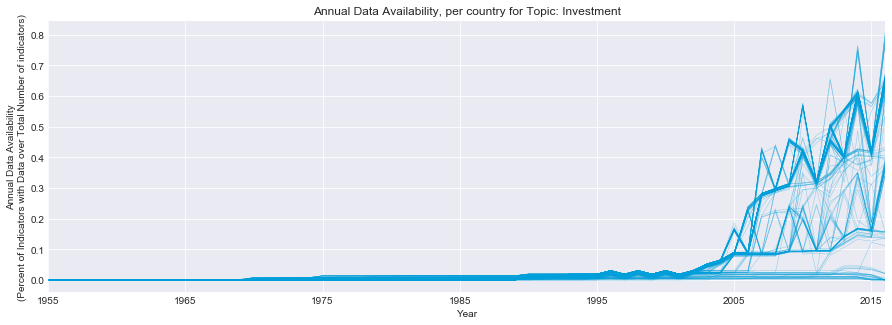

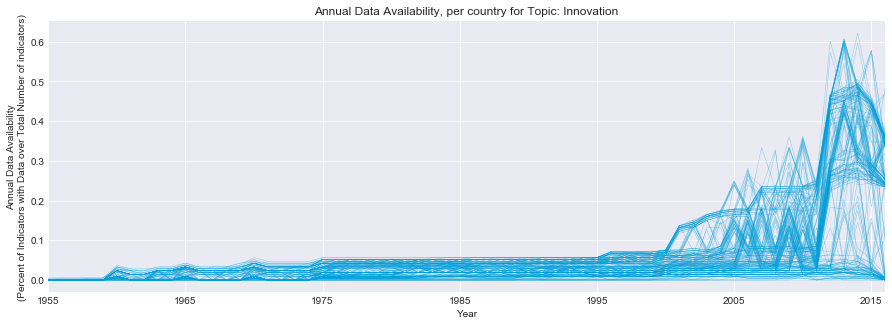

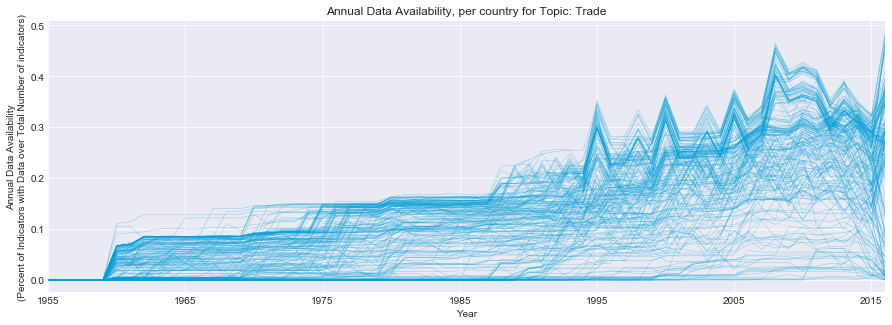

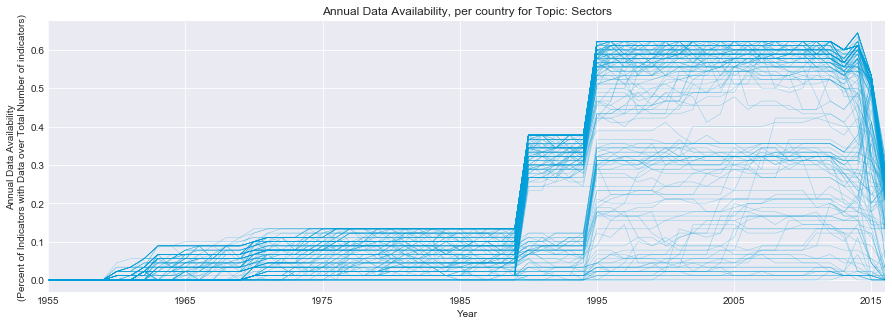

In [152]:
# topic = topic_list[0]
for topic in topic_list:
    indicators_per_topic = len(df_merged2[df_merged2['topiclvl1'] == topic]['indicatorId'].unique())
    by_country_topic = df_merged2[df_merged2['topiclvl1'] == topic].groupby('Country ISO3')[list_timeframe_all].sum()/indicators_per_topic
    by_country_topic[list_timeframe_all].T.plot(color='#009fda', lw=0.5, alpha=0.4, figsize=(15,5))
    plt.title("Annual Data Availability, per country for Topic: %s" % topic)
    plt.ylabel("Annual Data Availability\n(Percent of Indicators with Data over Total Number of indicators)")
    plt.xlabel("Year")
    plt.legend([])
    plt.show()

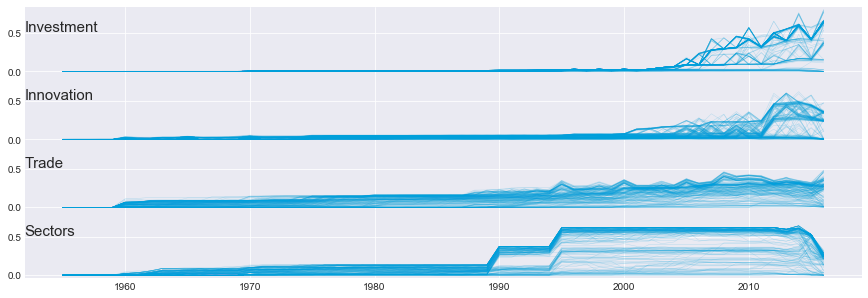

In [154]:
f, axarr = plt.subplots(len(topic_list), sharex=True, sharey=True, figsize=(15,5))

count = 0
for topic in topic_list:
    indicators_per_topic = len(df_merged2[df_merged2['topiclvl1'] == topic]['indicatorId'].unique())
    by_country_topic = df_merged2[df_merged2['topiclvl1'] == topic].groupby('Country ISO3')[list_timeframe_all].sum()/indicators_per_topic
    axarr[count].plot(by_country_topic[list_timeframe_all].T, color='#009fda', lw=0.5, alpha=0.2)
    axarr[count].set_title("%s" % topic, loc='left', y=0.55,fontsize=15)
    count += 1

f.subplots_adjust(hspace=0)
plt.legend([])
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

In [209]:
subtopic_list = df_merged2['topiclvl2'].unique()

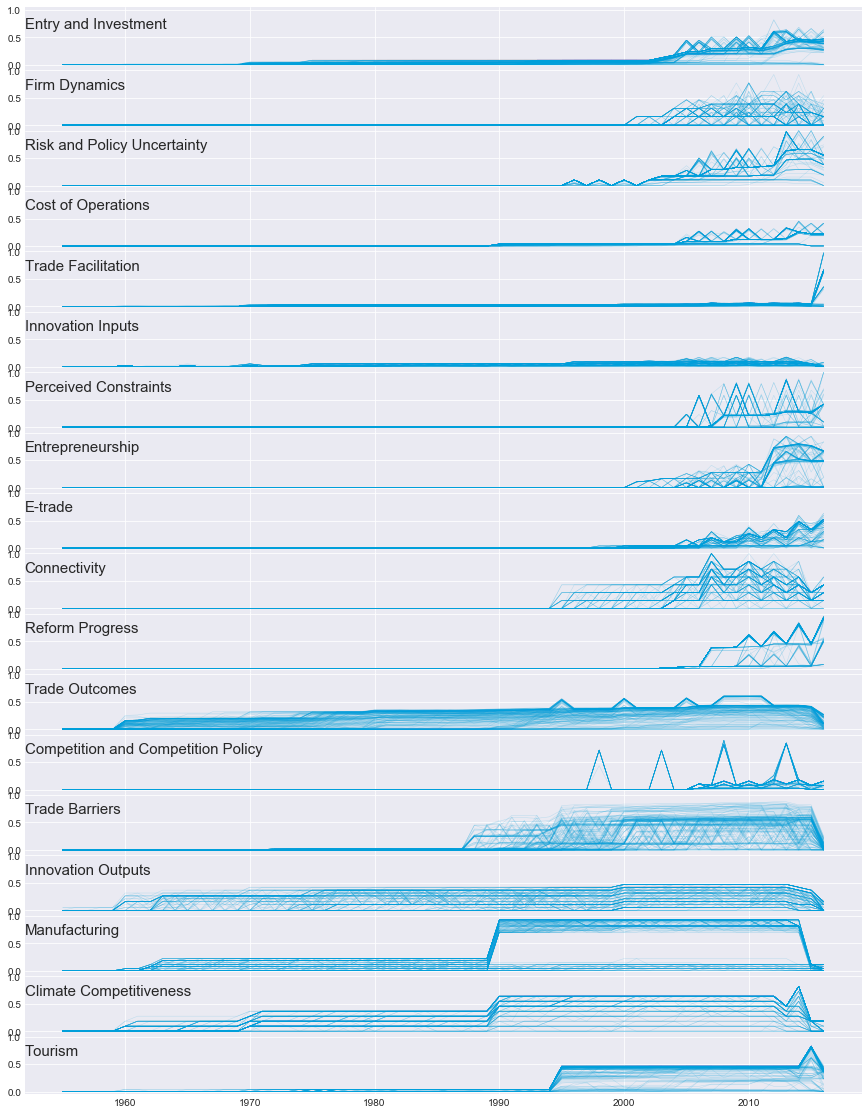

In [211]:
f, axarr = plt.subplots(len(subtopic_list), sharex=True, sharey=True, figsize=(15,20))

count = 0
for topic in subtopic_list:
    indicators_per_topic = len(df_merged2[df_merged2['topiclvl2'] == topic]['indicatorId'].unique())
    by_country_topic = df_merged2[df_merged2['topiclvl2'] == topic].groupby('Country ISO3')[list_timeframe_all].sum()/indicators_per_topic
    axarr[count].plot(by_country_topic[list_timeframe_all].T, color='#009fda', lw=0.5, alpha=0.2)
    axarr[count].set_title("%s" % topic, loc='left', y=0.55,fontsize=15)
    count += 1

f.subplots_adjust(hspace=0)
plt.legend([])
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()